<h2><b>Importing libraries</b></h2>

In [1134]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import mplfinance as mpf
from pandas_datareader import data
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix, precision_score
from sklearn.metrics import mean_absolute_error, roc_curve, auc
from sklearn.metrics import mean_squared_error
import math
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
import time
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

<h2><b>Getting data</b></h2>

In [1135]:
histEmbr = web.DataReader('EMBR3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histOi = web.DataReader('OIBR3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histMglu = web.DataReader('MGLU3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histAmbv = web.DataReader('ABEV3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histBB = web.DataReader('BBAS3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histVale = web.DataReader('VALE3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histPetro = web.DataReader('PETR4.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histFlry = web.DataReader('FLRY3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histCgas = web.DataReader('CGAS5.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
# histRio = web.DataReader('VVAR3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-30")
# histOSX = web.DataReader('BBDC4.SA', data_source='yahoo', start="2018-01-01", end="2018-12-30")

In [1136]:
# historicStock = [histVale, histAzul, histBB, histPetro, histItau, histRio, histOSX]
historicStock = [histEmbr, histOi, histMglu, histAmbv, histBB, histVale, histPetro, histFlry, histCgas]

In [1137]:
for stock in historicStock:
    print(stock.isnull().any().sum())

0
0
0
0
0
0
0
0
0


In [1138]:
historicStock[0].head()

High        Low       Open      Close     Volume  Adj Close
Date                                                                        
2018-01-02  20.990000  20.230000  20.629999  20.520000  3813300.0  20.389370
2018-01-03  21.600000  20.860001  21.049999  21.299999  9403700.0  21.164400
2018-01-04  22.200001  21.500000  21.500000  21.799999  6597700.0  21.661217
2018-01-05  22.129999  20.650000  21.900000  20.650000  8980400.0  20.518539
2018-01-08  21.170000  20.500000  21.059999  20.700001  4798500.0  20.568220

In [1139]:
monthlyInflation2018 = [0.0076, 0.0007, 0.0064, 0.0057, 0.0138, 0.0187, 0.0051, 0.0070, 0.0152, 0.0089, -0.0049, -0.0108]

<h2><b>Calculating daily inflation</b></h2>

In [1140]:
dayMonth30 = [4,6,9,11]
dayMonth31 = [1,3,5,7,8,10,12]
        
def calculate_daily_inflation(monthlyInflation):
    dailyInflation = []
    inflationHigh = []
    inflationLow = []
    inflationOpen = []
    inflationClose = []
    
    for index, inf in enumerate(monthlyInflation):
        if np.isin(index, dayMonth30):
            dailyInflation.append((1 + inf) ** (1/float(30)))
        elif np.isin(index, dayMonth31):
            dailyInflation.append((1 + inf) ** (1/float(31)))
        else:
            dailyInflation.append((1 + inf) ** (1/float(28)))
    
    for stock in historicStock:
        stock["Month"] = stock.index.month
        total = 1
        inflation = []
        for index, row in stock.iterrows():
            month = int(row['Month'])
            if dailyInflation[month - 1] >= 1:
                total = total * dailyInflation[month - 1]
            else:
                total = total / dailyInflation[month - 1]
            inflation.append(total)
        stock["DailyInflation"] = inflation
        
    for stock in historicStock:
        for index, row in stock.iterrows():
            inflationHigh = round(stock["High"] / stock["DailyInflation"], 2)
            inflationLow = round(stock["Low"] / stock["DailyInflation"], 2)
            inflationOpen = round(stock["Open"] / stock["DailyInflation"], 2)
            inflationClose = round(stock["Close"] / stock["DailyInflation"], 2) 
        stock["InflationHigh"] = inflationHigh
        stock["InflationLow"] = inflationLow
        stock["InflationOpen"] = inflationOpen
        stock["InflationClose"] = inflationClose

In [1141]:
calculate_daily_inflation(monthlyInflation2018)

<h2><b>Calculating short and long EMAs, MACD and Signal lines</b></h2>

In [1142]:
def calculate_lines():
    for stock in historicStock:
        stock["ShortEMA"] = stock["Close"].ewm(span = 12, adjust = False).mean()
        stock["LongEMA"] = stock["Close"].ewm(span = 26, adjust = False).mean()
        stock["MACD"] = stock["ShortEMA"] - stock["LongEMA"]
        stock["Signal"] = stock["MACD"].ewm(span = 9, adjust = False).mean()
        stock["InflationShortEMA"] = stock["InflationClose"].ewm(span = 12, adjust = False).mean()
        stock["InflationLongEMA"] = stock["InflationClose"].ewm(span = 26, adjust = False).mean()
        stock["InflationMACD"] = stock["InflationShortEMA"] - stock["InflationLongEMA"]
        stock["InflationSignal"] = stock["InflationMACD"].ewm(span = 9, adjust = False).mean()

In [1143]:
calculate_lines()

In [1144]:
def plot_emas(stocks, inflation=False):
    for stock in stocks:
        plt.figure(figsize = (14,10))
        plt.plot(stock["ShortEMA"], label="ShortEMA")
        plt.plot(stock["LongEMA"], label="LongEMA")
        plt.plot(stock["Close"], label="Close", alpha=0.3)
        plt.legend()
        plt.xlabel('Tempo')
        plt.ylabel('Valores/Preço')
        plt.title("EMAs")
        plt.show()

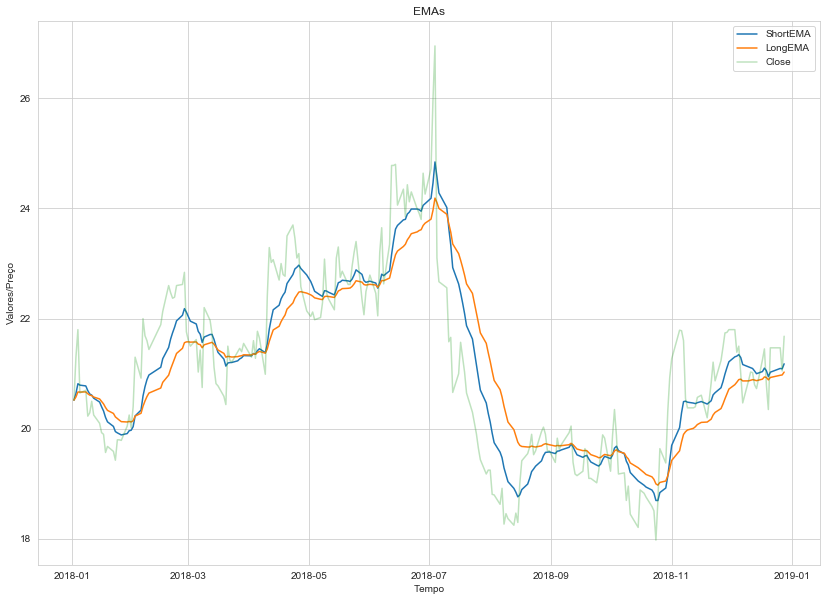

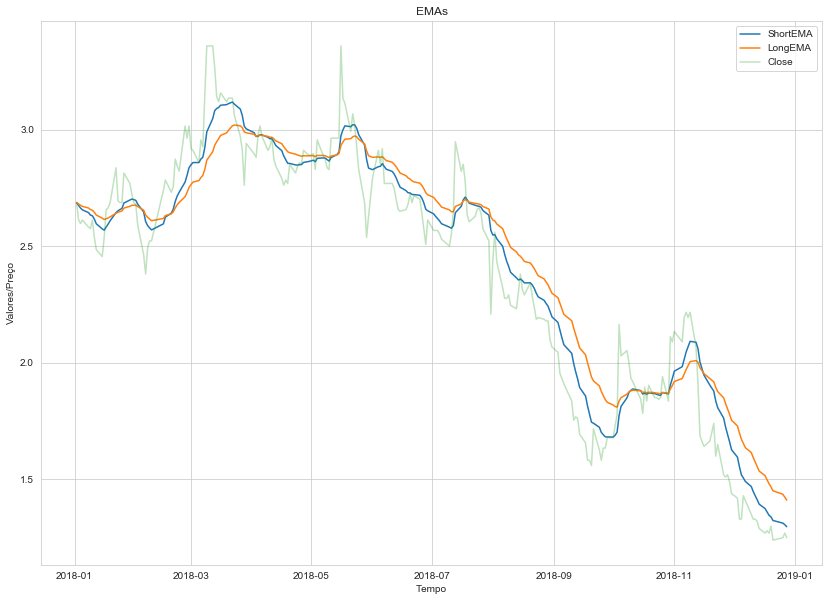

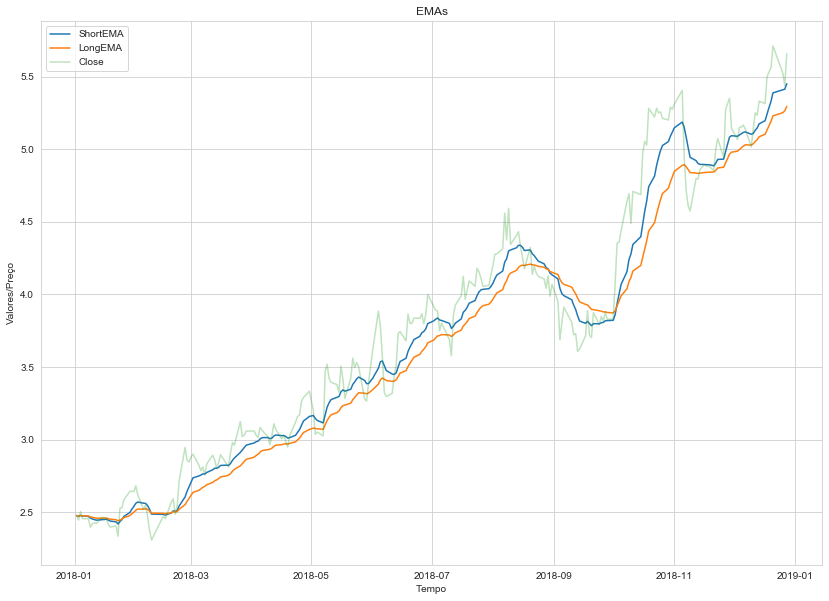

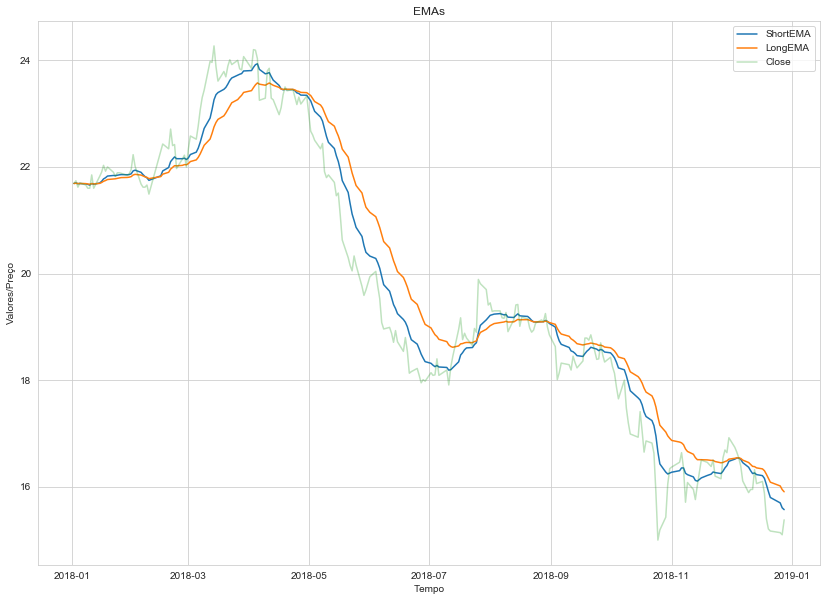

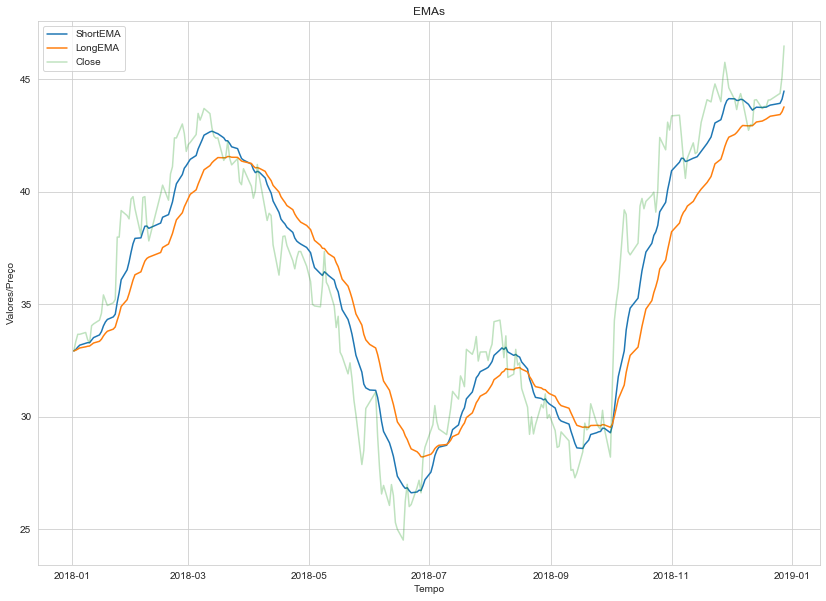

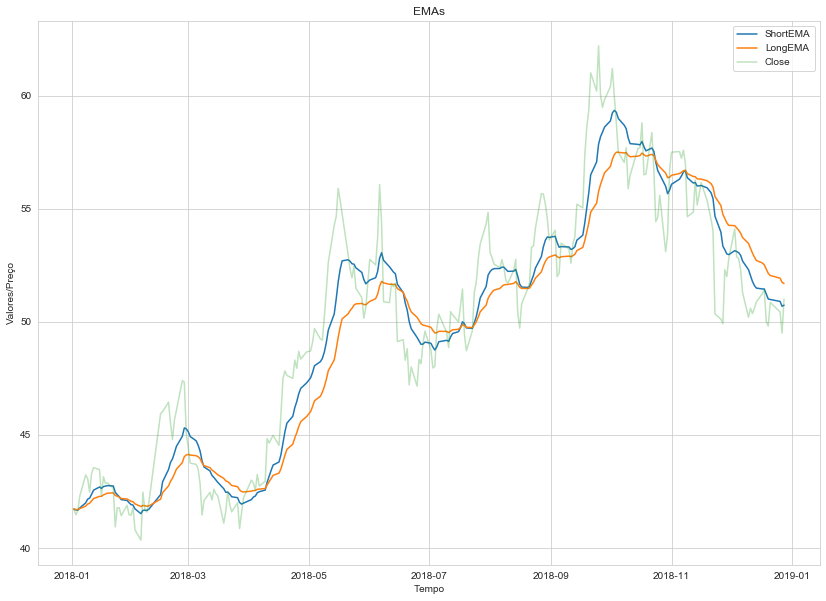

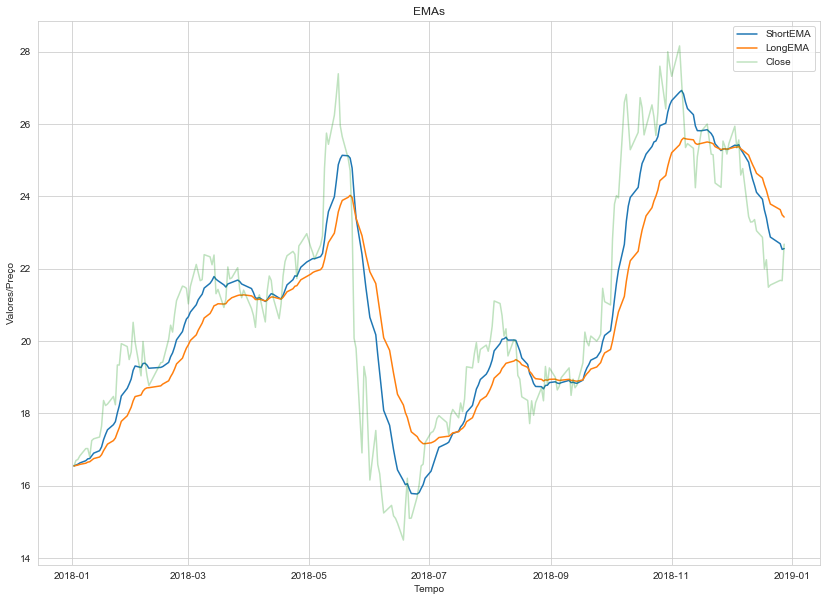

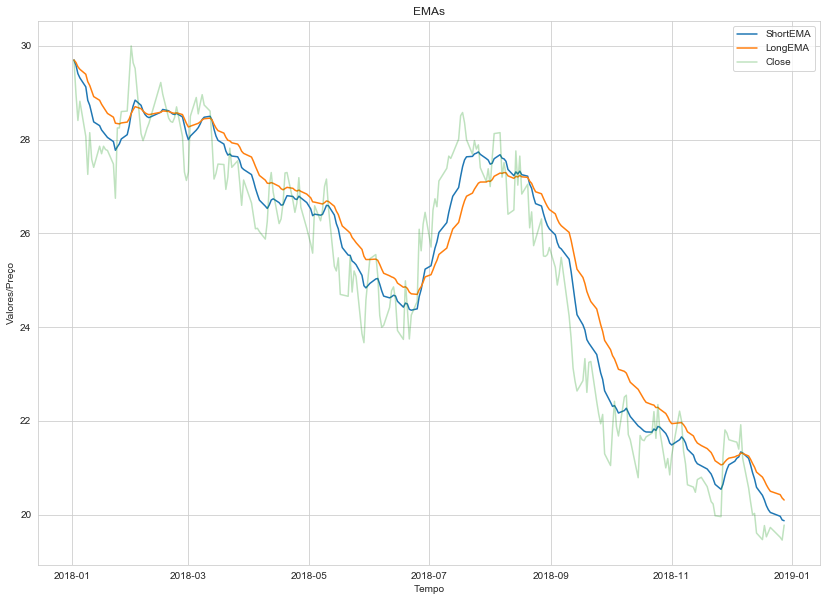

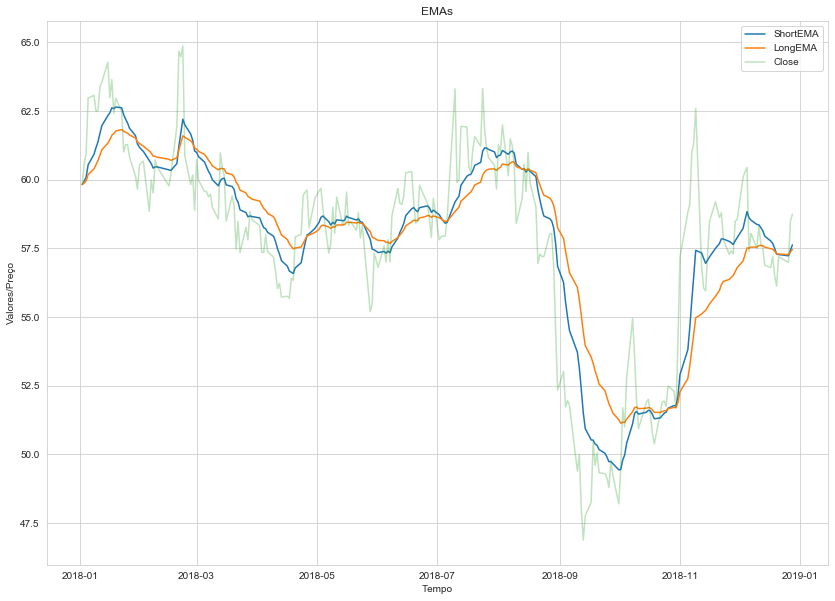

In [1145]:
plot_emas(historicStock)

In [1146]:
def plot_macd_signal(stocks, inflation=False):
    for stock in stocks:
        scaler = MinMaxScaler()
        stockScaled = pd.DataFrame(scaler.fit_transform(stock), columns=stock.columns)
        plt.figure(figsize = (14,10))
        if inflation == False:
            ax = stockScaled["MACD"].plot()
            ax = stockScaled["Signal"].plot()
            stockScaled["Close"].plot(alpha=0.3)
        else:
            ax = stockScaled["InflationMACD"].plot()
            ax = stockScaled["InflationSignal"].plot()
            stockScaled["InflationClose"].plot(alpha=0.3)
        plt.legend()
        plt.xlabel('Tempo')
        plt.ylabel('Valor/Preço')
        plt.title("MACD e Signal")
        plt.show()

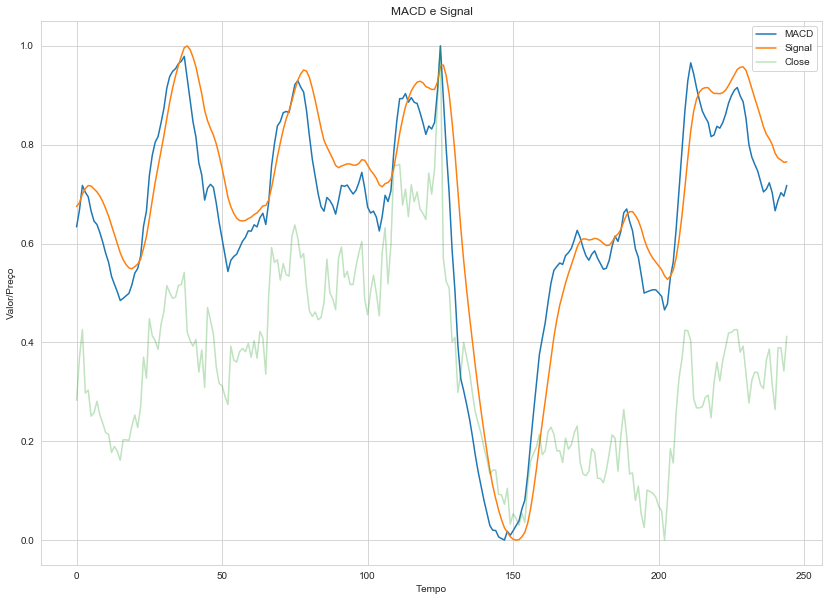

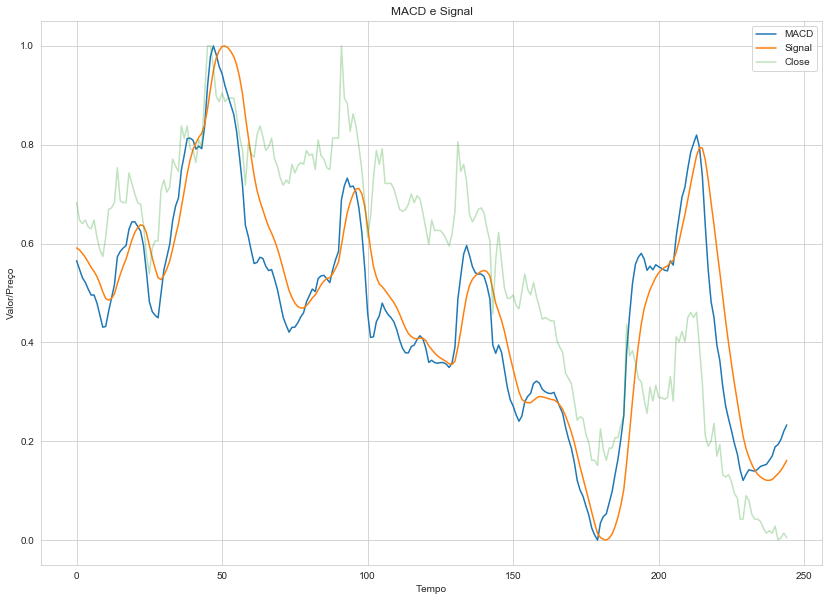

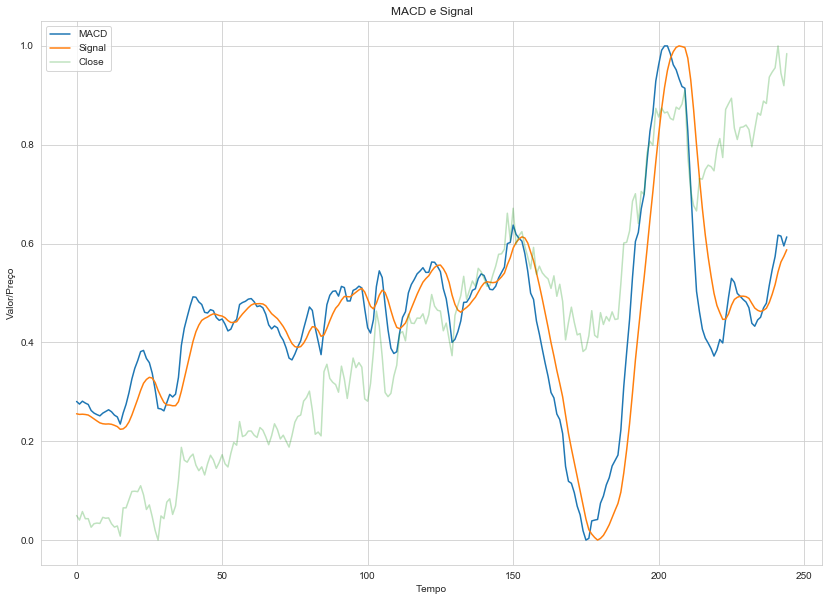

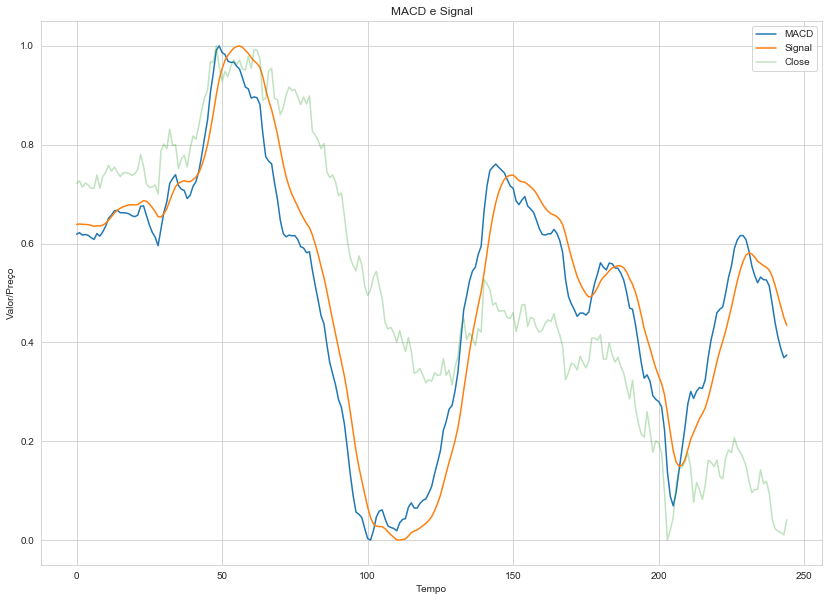

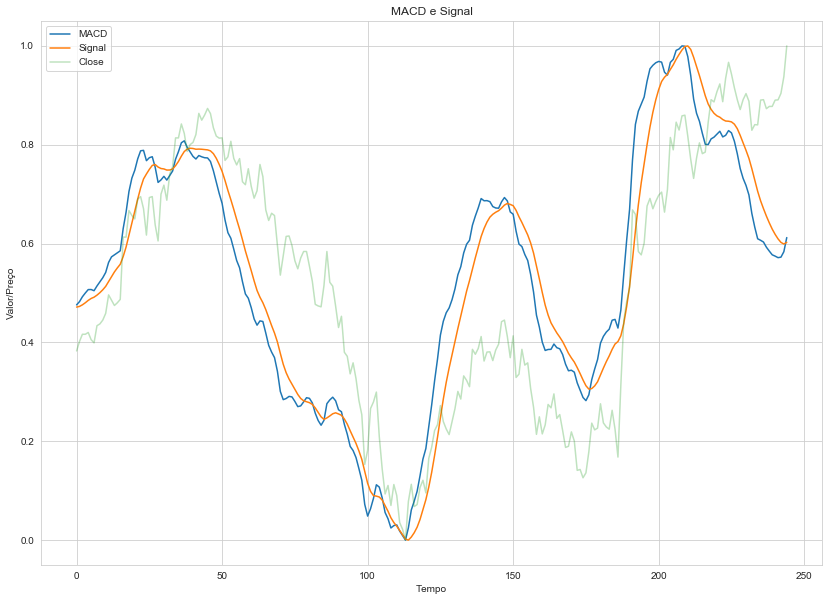

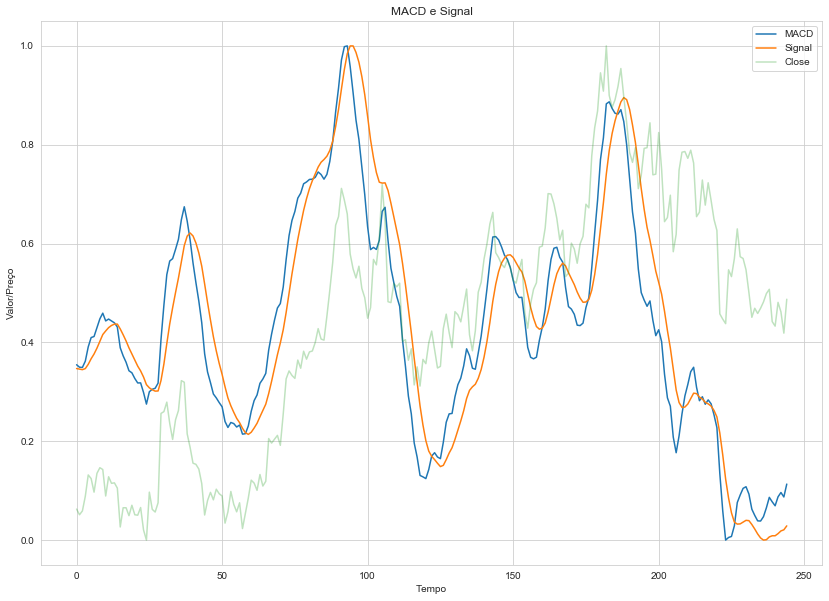

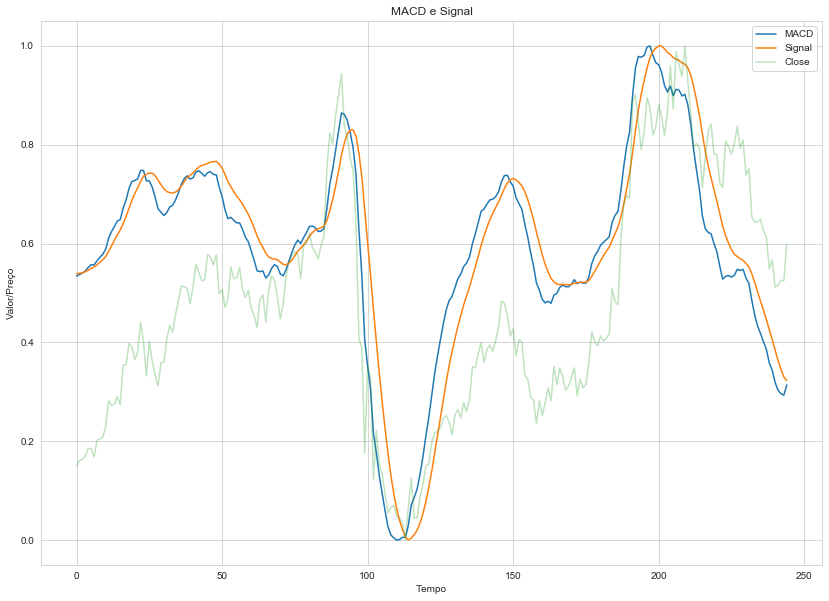

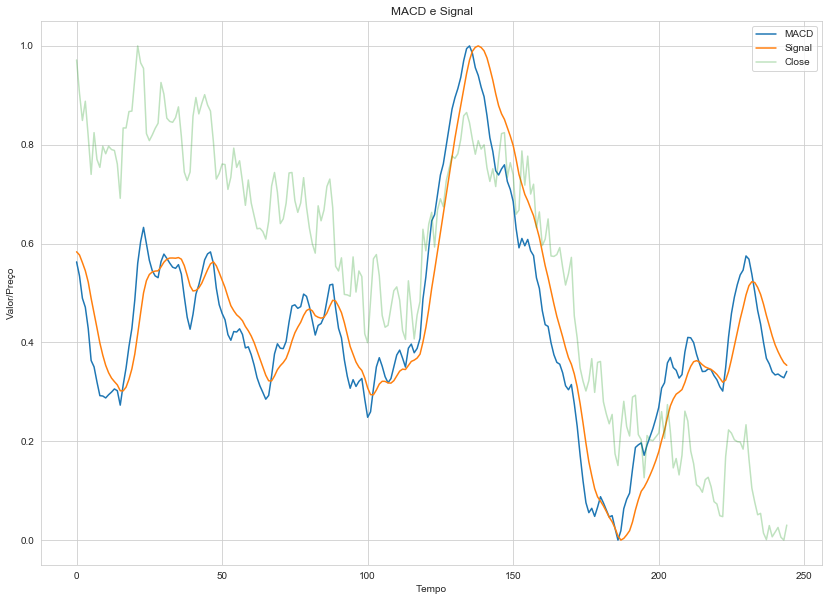

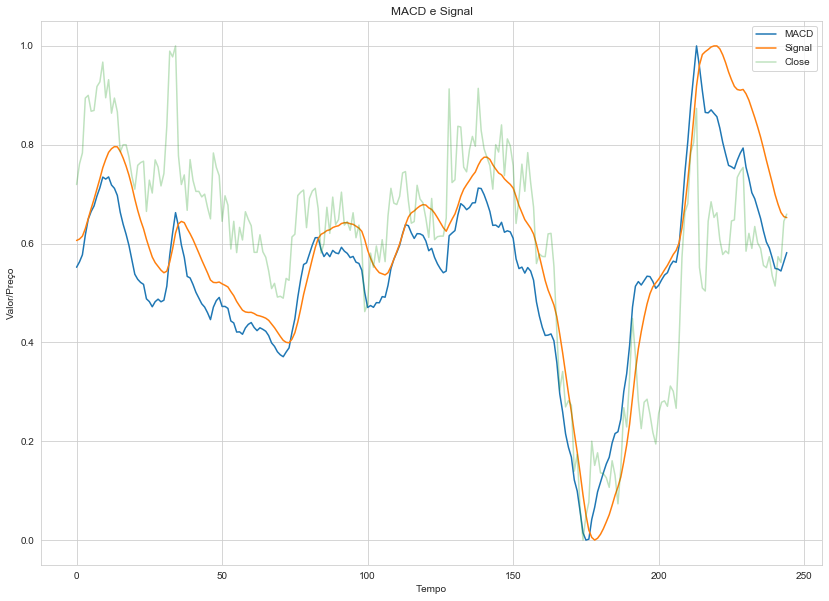

In [1147]:
plot_macd_signal(historicStock)

In [1148]:
def calculate_bollinger_bands():
    for stock in historicStock:
        stock["30_MA"] = stock["Close"].rolling(window=20).mean()
        stock["30_STD"] = stock["Close"].rolling(window=20).std()
        stock["UpperBollinger"] = stock["30_MA"] + 2 * stock["30_STD"]
        stock["LowerBollinger"] = stock["30_MA"] - 2 * stock["30_STD"]
        stock["DifferenceUpper"] = stock["UpperBollinger"] - stock["Close"]
        stock["DifferenceLower"] = stock["LowerBollinger"] - stock["Close"]
        
        stock["Inflation30_MA"] = stock["InflationClose"].rolling(window=20).mean()
        stock["Inflation30_STD"] = stock["InflationClose"].rolling(window=20).std()
        stock["InflationUpperBollinger"] = stock["Inflation30_MA"] + 2 * stock["Inflation30_STD"]
        stock["InflationLowerBollinger"] = stock["Inflation30_MA"] - 2 * stock["Inflation30_STD"]
        stock["InflationDifferenceUpper"] = stock["InflationUpperBollinger"] - stock["InflationClose"]
        stock["InflationDifferenceLower"] = stock["InflationLowerBollinger"] - stock["InflationClose"]
        
        plt.figure(figsize = (14,10))
        plt.plot(stock["LowerBollinger"], label="Lower")
        plt.plot(stock["UpperBollinger"], label="Upper")
        plt.plot(stock["Close"], label="Close")
        plt.legend()
        plt.xlabel('Tempo')
        plt.ylabel('Preço')
        plt.title("Bandas de Bollinger")
        plt.show()

In [1149]:
def calculate_bollinger_bands_stock(stock, inflation=False):
    if(inflation == False):
        stock["30_MA"] = stock["Close"].rolling(window=20).mean()
        stock["30_STD"] = stock["Close"].rolling(window=20).std()
        stock["UpperBollinger"] = stock["30_MA"] + 2 * stock["30_STD"]
        stock["LowerBollinger"] = stock["30_MA"] - 2 * stock["30_STD"]
        stock["DifferenceUpper"] = stock["UpperBollinger"] - stock["Close"]
        stock["DifferenceLower"] = stock["LowerBollinger"] - stock["Close"]
    else:
        stock["Inflation30_MA"] = stock["InflationClose"].rolling(window=20).mean()
        stock["Inflation30_STD"] = stock["InflationClose"].rolling(window=20).std()
        stock["InflationUpperBollinger"] = stock["Inflation30_MA"] + 2 * stock["Inflation30_STD"]
        stock["InflationLowerBollinger"] = stock["Inflation30_MA"] - 2 * stock["Inflation30_STD"]
        stock["InflationDifferenceUpper"] = stock["InflationUpperBollinger"] - stock["InflationClose"]
        stock["InflationDifferenceLower"] = stock["InflationLowerBollinger"] - stock["InflationClose"]

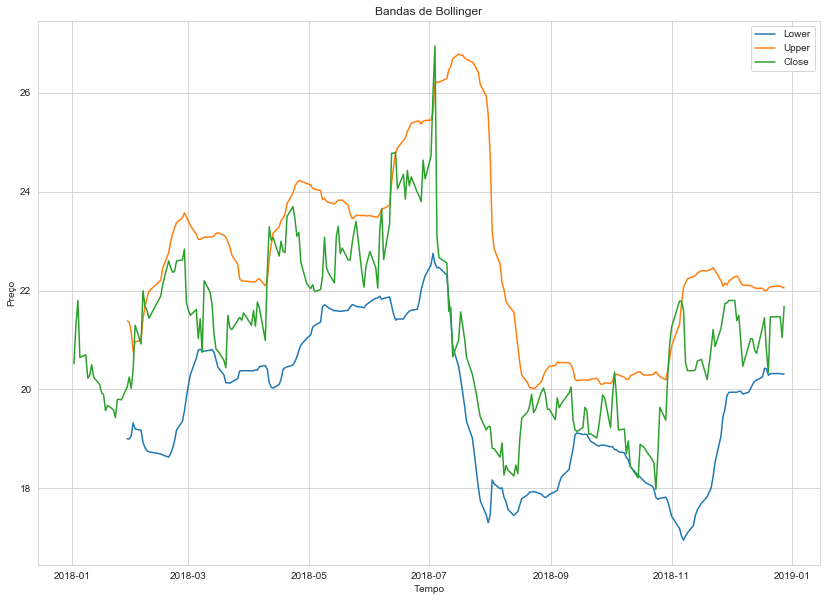

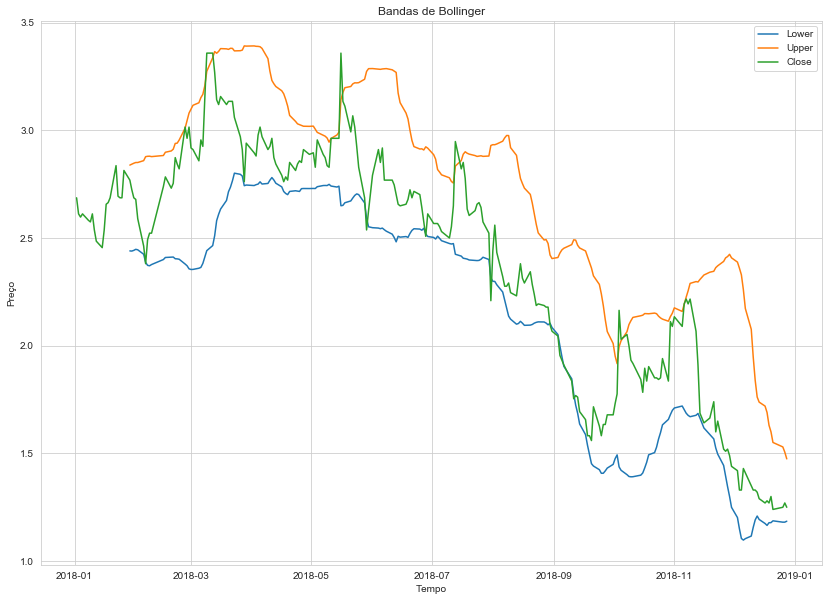

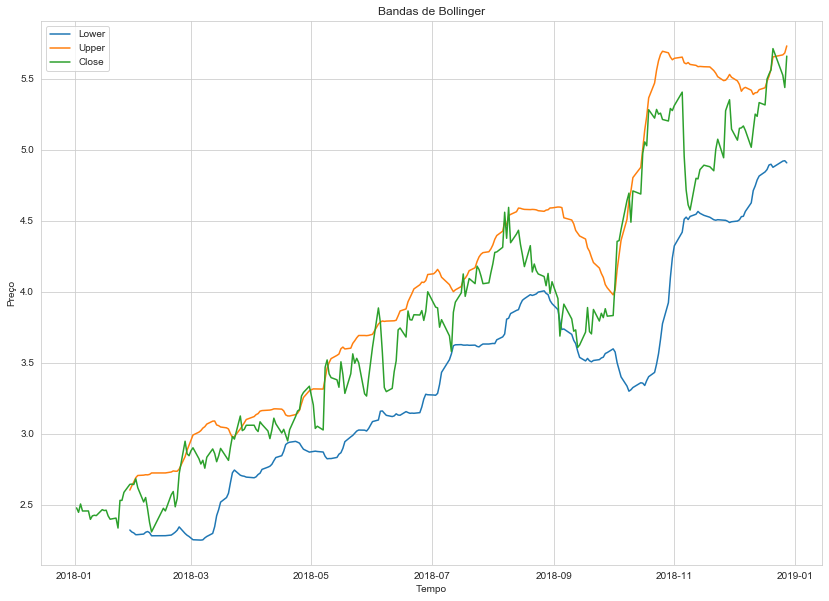

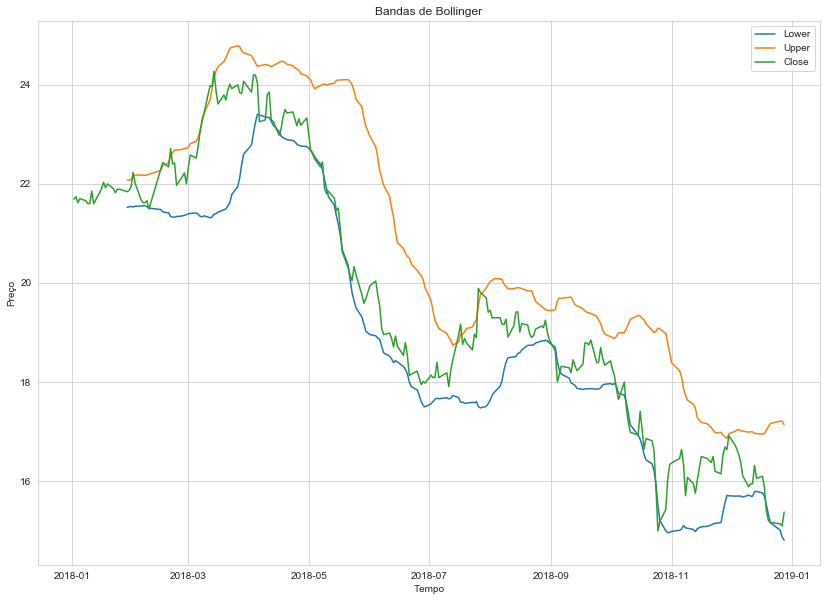

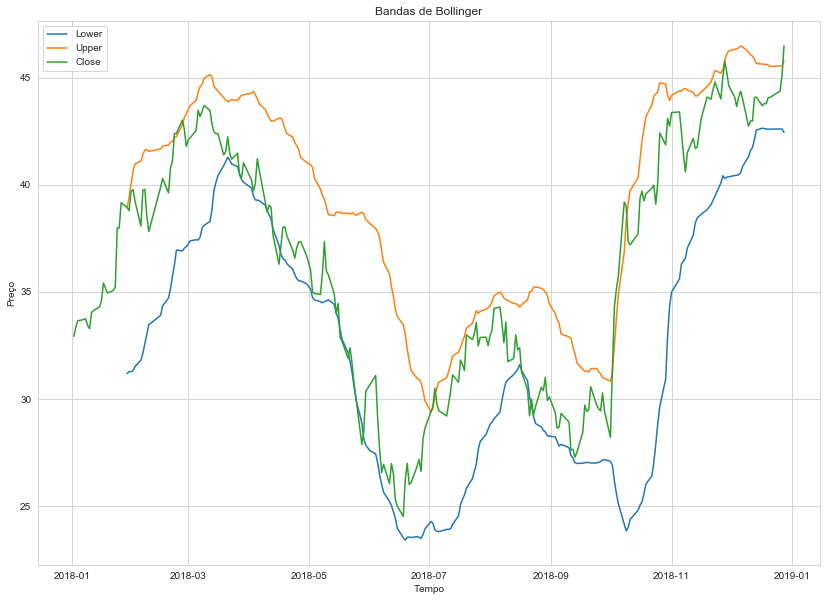

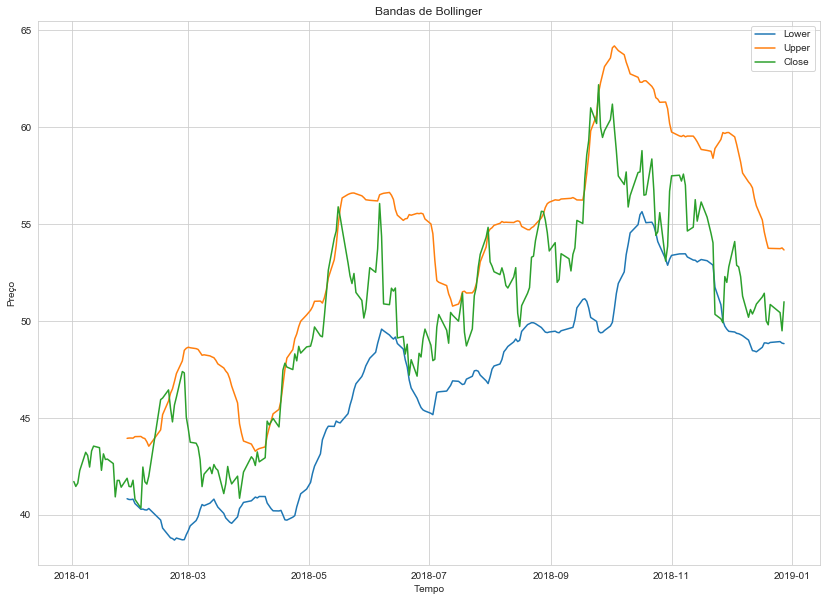

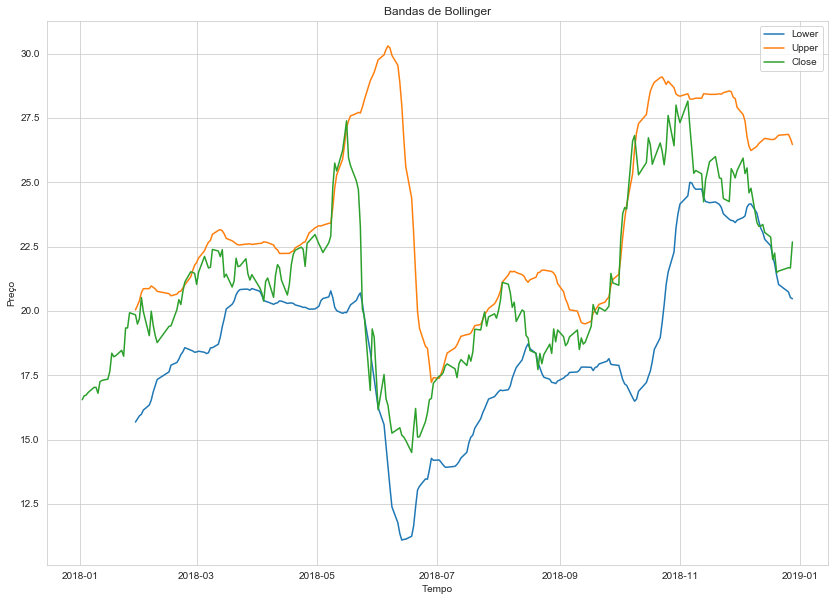

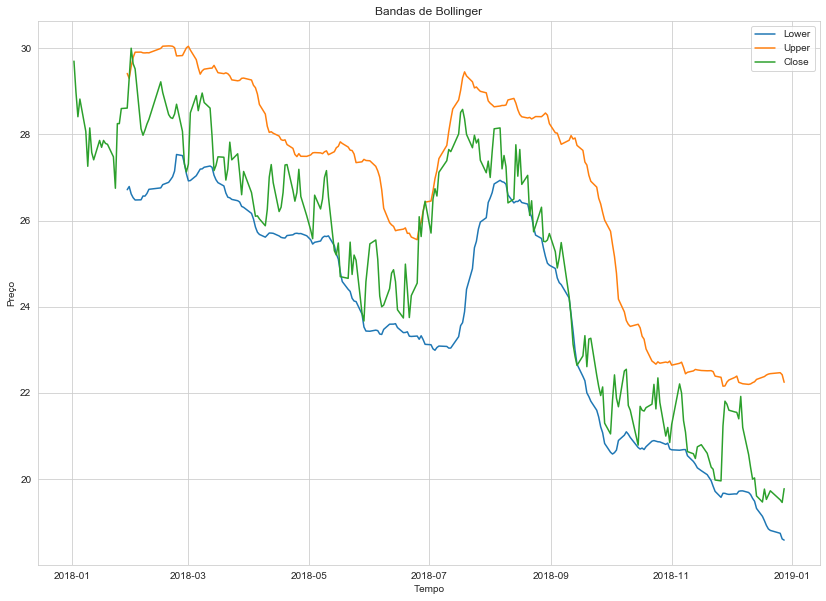

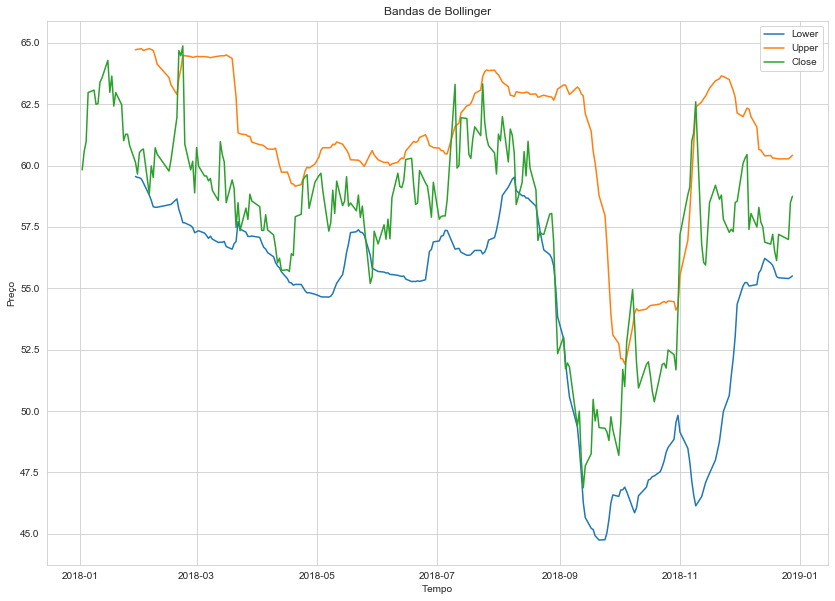

In [1150]:
calculate_bollinger_bands()

In [1151]:
def upOrDown():
    for stock in historicStock:
        stock["UpDown"] = stock["Close"].diff();
        stock["UpDown"] = stock["UpDown"].apply(lambda x: 1 if x >= 0 else 0)

In [1152]:
def upOrDownNpArray(array):
    difference = np.diff(array)
    diffReturn = []
    for i in difference:
        if i >= 0:
            diffReturn.append(1)
        else:
            diffReturn.append(0)
    return np.array(diffReturn)

In [1153]:
def upOrDownStock(stock):
    stock["UpDown"] = stock["Close"].diff();
    stock["UpDown"] = stock["UpDown"].apply(lambda x: 1 if x >= 0 else 0)

In [1154]:
upOrDown()

<h2><b>Calculating Relative Strength Index (RSI)</b></h2>

In [1155]:
def calculate_RSI(window):
    for stock in historicStock:
        delta = stock["Close"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["RSI"] = rsi
        
        delta = stock["InflationClose"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["InflationRSI"] = rsi

In [1156]:
def calculate_RSI_stock(window, stock, inflation=False):
    if inflation == False:
        delta = stock["Close"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["RSI"] = rsi
    else:
        delta = stock["InflationClose"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["InflationRSI"] = rsi

In [1157]:
calculate_RSI(14)

<h2><b>Function to plot RSI</b></h2>

In [1158]:
def plot_rsi_close(stock, stockName, inflation=False):
    scaler = MinMaxScaler()
    stockScaled = pd.DataFrame(scaler.fit_transform(stock), columns=stock.columns)

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stockScaled["RSI"].plot()
        stockScaled["Close"].plot()
    else:
        ax = stockScaled["InflationRSI"].plot()
        stockScaled["InflationClose"].plot()
    ax.axhline(y = 0.7, color = 'red')
    ax.axhline(y = 0.3, color = 'lime')
    plt.title(f'Relação RSI e Close da {stockName}')
    plt.xlabel('Tempo')
    plt.ylabel('Valor/Preço')
    plt.legend()
    plt.show()

In [1159]:
def plot_rsi_close_all_stocks(stocks, inflation=False):
    for stock in stocks:
        scaler = MinMaxScaler()
        stockScaled = pd.DataFrame(scaler.fit_transform(stock), columns=stock.columns)

        plt.figure(figsize = (14, 10))
        if inflation == False:
            ax = stockScaled["RSI"].plot()
            stockScaled["Close"].plot()
        else:
            ax = stockScaled["InflationRSI"].plot()
            stockScaled["InflationClose"].plot()
        ax.axhline(y = 0.7, color = 'red')
        ax.axhline(y = 0.3, color = 'lime')
        plt.title('Relação RSI e Close')
        plt.xlabel('Tempo')
        plt.ylabel('Valor/Preço normalizado')
        plt.legend()
        plt.show()

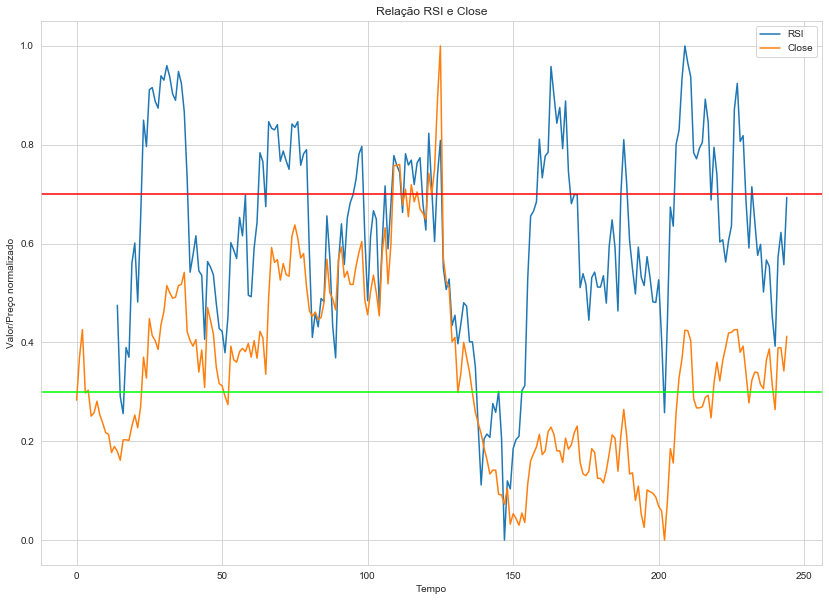

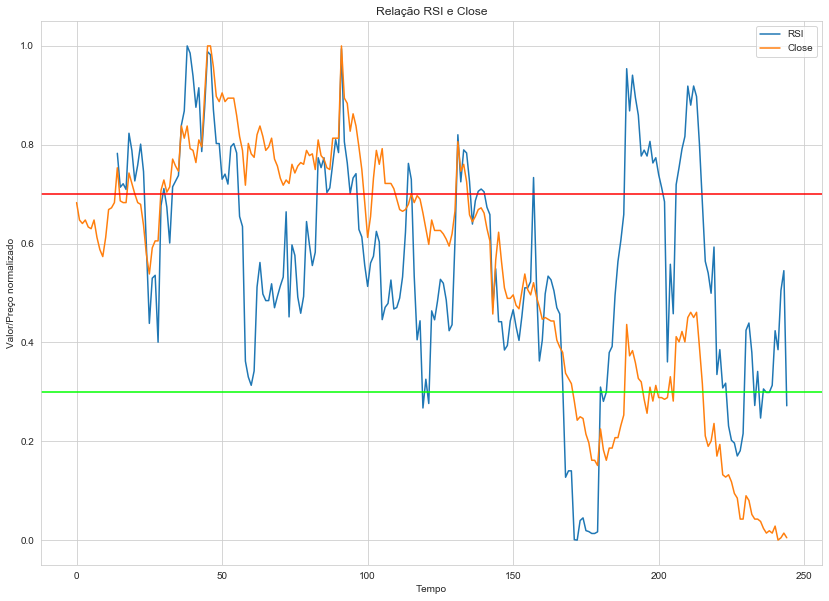

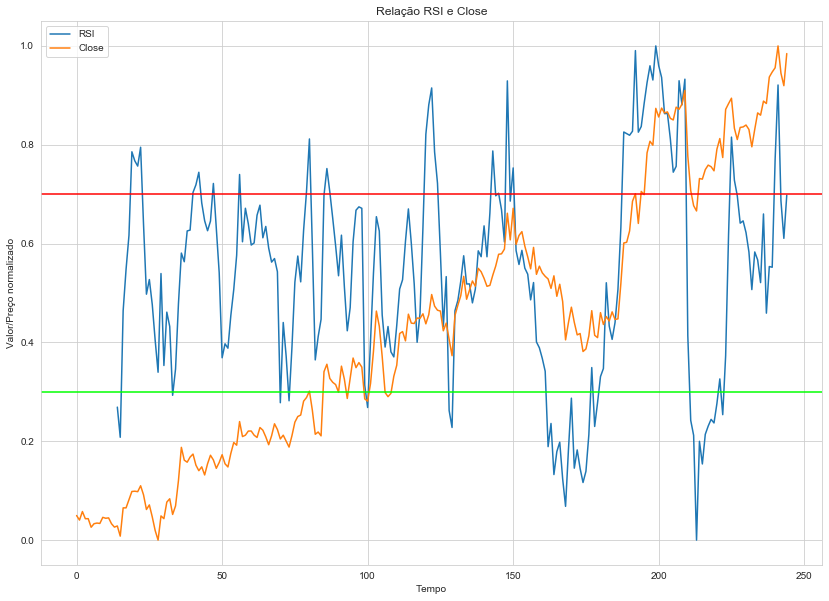

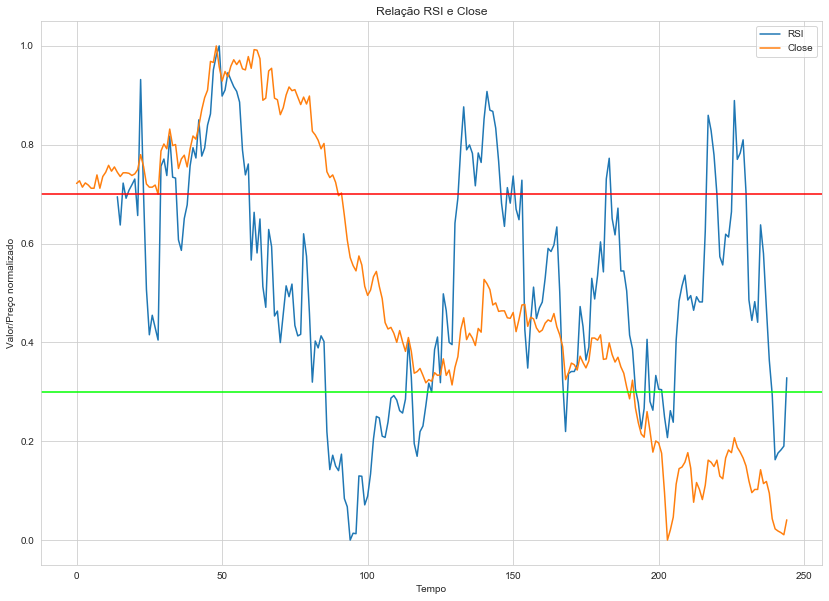

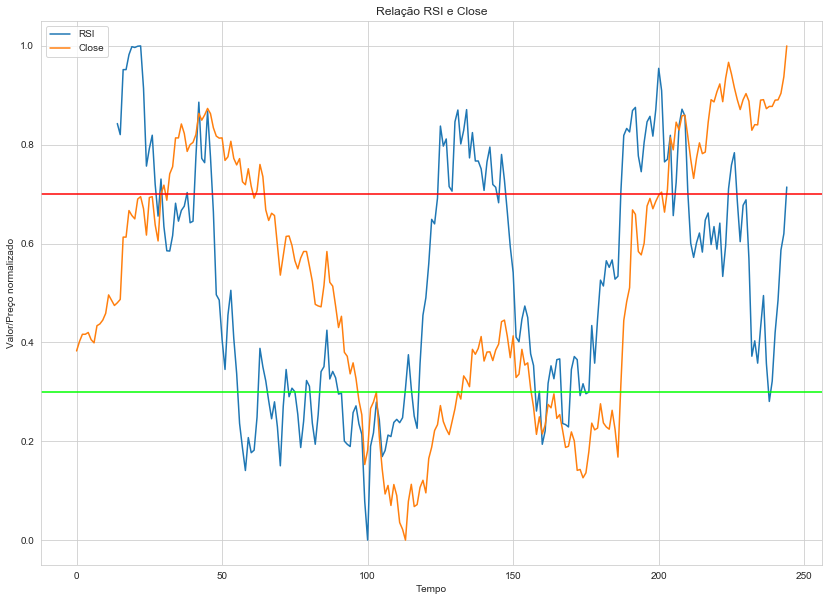

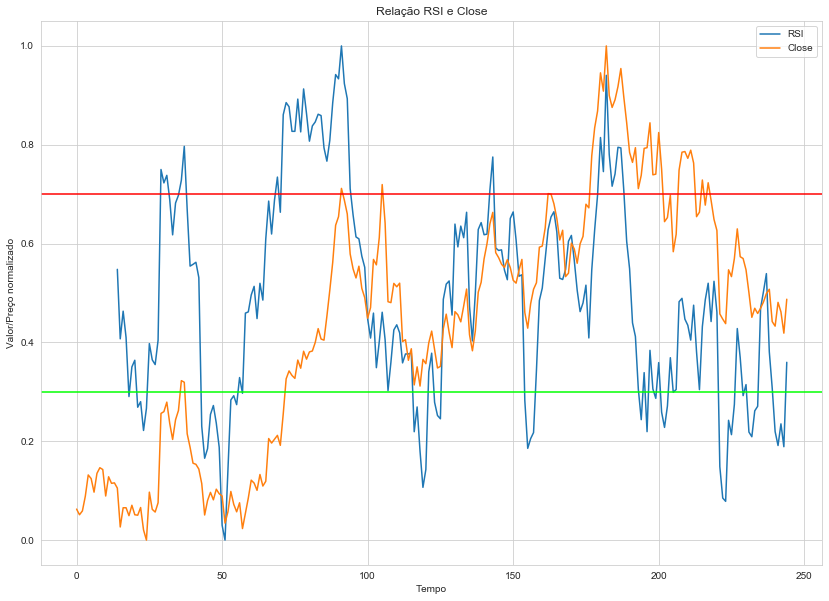

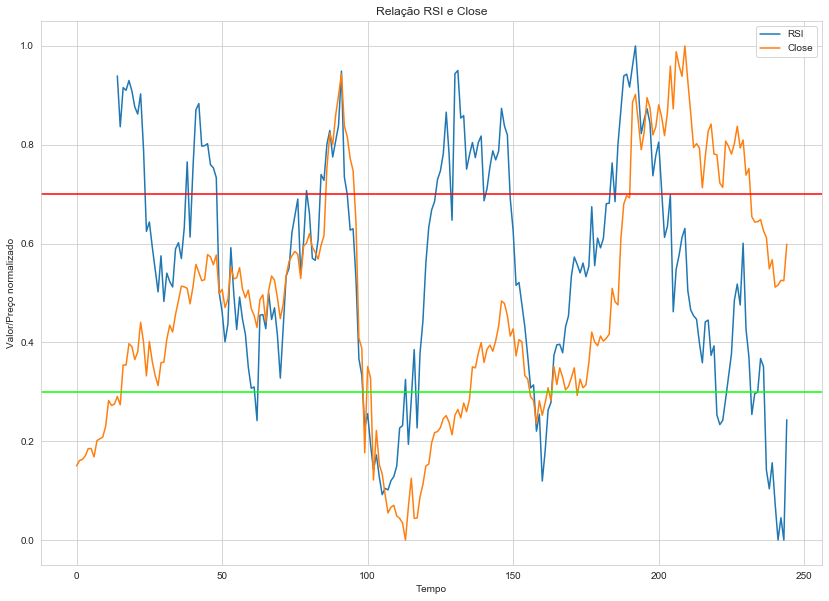

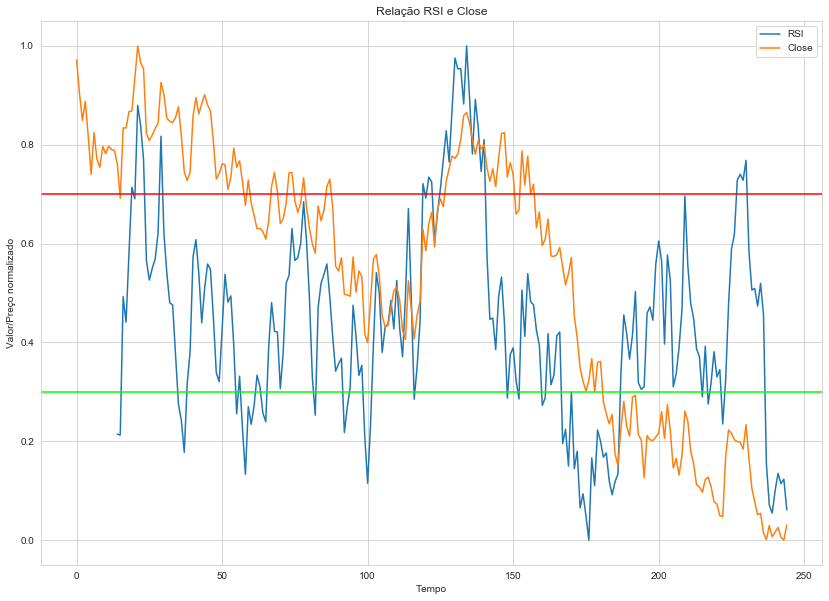

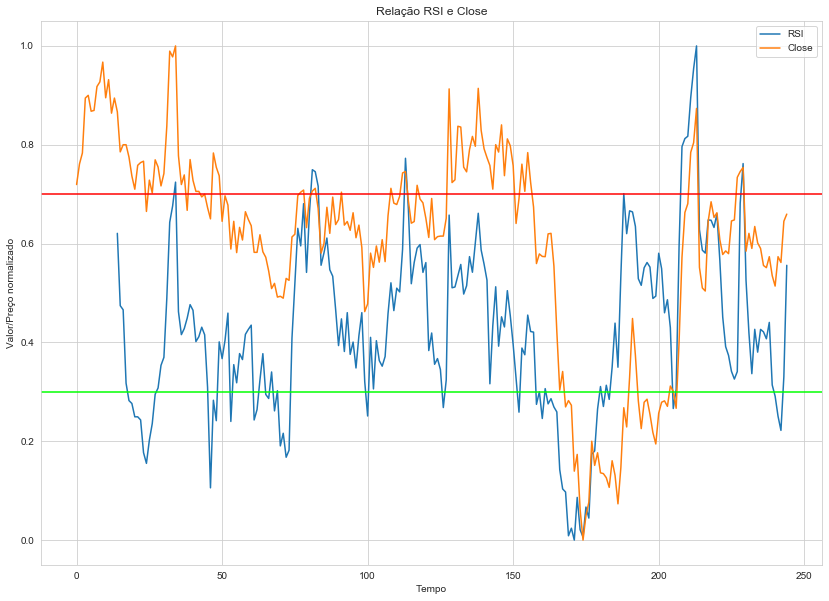

In [1160]:
plot_rsi_close_all_stocks(historicStock)

<h2><b>Calculating Money Flow Index (MFI)</b></h2>

In [1161]:
def calculate_MFI(window):
    for stock in historicStock:
        stock["TypicalPrice"] = (stock["High"] + stock["Low"] + stock["Close"]) / 3
        delta = stock["TypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["TypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["TypicalPrice"]
        stock["1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["nDayPositiveMoneyFlow"] = stock["1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["nDayNegativeMoneyFlow"] = stock["1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["MoneyFlowRatio"] = stock["nDayPositiveMoneyFlow"] / stock["nDayNegativeMoneyFlow"]
        stock["MoneyFlowIndex"] = 100 - (100 / (1 + stock["MoneyFlowRatio"]))

        stock["InflationTypicalPrice"] = (stock["InflationHigh"] + stock["InflationLow"] + stock["InflationClose"]) / 3
        delta = stock["InflationTypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["InflationTypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["InflationTypicalPrice"]
        stock["Inflation1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["Inflation1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["InflationnDayPositiveMoneyFlow"] = stock["Inflation1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["InflationnDayNegativeMoneyFlow"] = stock["Inflation1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["InflationMoneyFlowRatio"] = stock["InflationnDayPositiveMoneyFlow"] / stock["InflationnDayNegativeMoneyFlow"]
        stock["InflationMoneyFlowIndex"] = 100 - (100 / (1 + stock["InflationMoneyFlowRatio"]))

In [1162]:
def calculate_MFI_stock(window, stock, inflation=False):
    if inflation == False:
        stock["TypicalPrice"] = (stock["High"] + stock["Low"] + stock["Close"]) / 3
        delta = stock["TypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["TypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["TypicalPrice"]
        stock["1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["nDayPositiveMoneyFlow"] = stock["1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["nDayNegativeMoneyFlow"] = stock["1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["MoneyFlowRatio"] = stock["nDayPositiveMoneyFlow"] / stock["nDayNegativeMoneyFlow"]
        stock["MoneyFlowIndex"] = 100 - (100 / (1 + stock["MoneyFlowRatio"]))
    else:
        stock["InflationTypicalPrice"] = (stock["InflationHigh"] + stock["InflationLow"] + stock["InflationClose"]) / 3
        delta = stock["InflationTypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["InflationTypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["InflationTypicalPrice"]
        stock["Inflation1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["Inflation1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["InflationnDayPositiveMoneyFlow"] = stock["Inflation1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["InflationnDayNegativeMoneyFlow"] = stock["Inflation1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["InflationMoneyFlowRatio"] = stock["InflationnDayPositiveMoneyFlow"] / stock["InflationnDayNegativeMoneyFlow"]
        stock["InflationMoneyFlowIndex"] = 100 - (100 / (1 + stock["InflationMoneyFlowRatio"]))

In [1163]:
calculate_MFI(14)

<h2><b>Function to plot MFI</b></h2>

In [1164]:
def plot_mfi(stock, stockName, inflation=False):

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stock["MoneyFlowIndex"].plot()
    else:
        ax = stock["InflationMoneyFlowIndex"].plot()
    ax.axhline(y = 20, color = 'red')
    ax.axhline(y = 80, color = 'lime')
    plt.title(f'MFI da {stockName}')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.legend()
    plt.show()

<h2><b>Calculating Stochastic Oscillator</b></h2>

In [1165]:
def calculate_stochastic_oscillator(window):
    for stock in historicStock:
        nHigh = stock["High"].rolling(window).max()
        nLow = stock["Low"].rolling(window).min()
        stock["StochasticOscillator"] = ((stock["Close"] - nLow) / (nHigh - nLow)) * 100
        
        nHigh = stock["InflationHigh"].rolling(window).max()
        nLow = stock["InflationLow"].rolling(window).min()
        stock["InflationStochasticOscillator"] = ((stock["InflationClose"] - nLow) / (nHigh - nLow)) * 100

In [1166]:
def calculate_stochastic_oscillator_stock(window, stock, inflation=False):
    if inflation == False:
        nHigh = stock["High"].rolling(window).max()
        nLow = stock["Low"].rolling(window).min()
        stock["StochasticOscillator"] = ((stock["Close"] - nLow) / (nHigh - nLow)) * 100
    else:  
        nHigh = stock["InflationHigh"].rolling(window).max()
        nLow = stock["InflationLow"].rolling(window).min()
        stock["InflationStochasticOscillator"] = ((stock["InflationClose"] - nLow) / (nHigh - nLow)) * 100

In [1167]:
calculate_stochastic_oscillator(14)

<h2><b>Function to plot Stochastic Oscillator</b></h2>

In [1168]:
def plot_stochastic_oscillator(stock, stockName, inflation=False):

    plt.figure(figsize = (14, 10))
    if inflation == False:
        ax = stock["StochasticOscillator"].plot()
    else:
        ax = stock["InflationStochasticOscillator"].plot()
    ax.axhline(y = 20, color = 'red')
    ax.axhline(y = 80, color = 'lime')
    plt.title(f'Oscilador estocástico da {stockName}')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.legend()
    plt.show()

In [1169]:
def plot_stochastic_oscillator_all_stocks(stocks, inflation=False):
    for stock in stocks:
        scaler = MinMaxScaler()
        stockScaled = pd.DataFrame(scaler.fit_transform(stock), columns=stock.columns)
        plt.figure(figsize = (14, 10))
        if inflation == False:
            ax = stockScaled["StochasticOscillator"].plot()
            stockScaled["Close"].plot()
        else:
            ax = stockScaled["InflationStochasticOscillator"].plot()
            stockScaled["InflationClose"].plot()
        ax.axhline(y = 0.2, color = 'red')
        ax.axhline(y = 0.8, color = 'lime')
        plt.title('Oscilador estocástico')
        plt.xlabel('Tempo')
        plt.ylabel('Valor/Preço')
        plt.legend()
        plt.show()

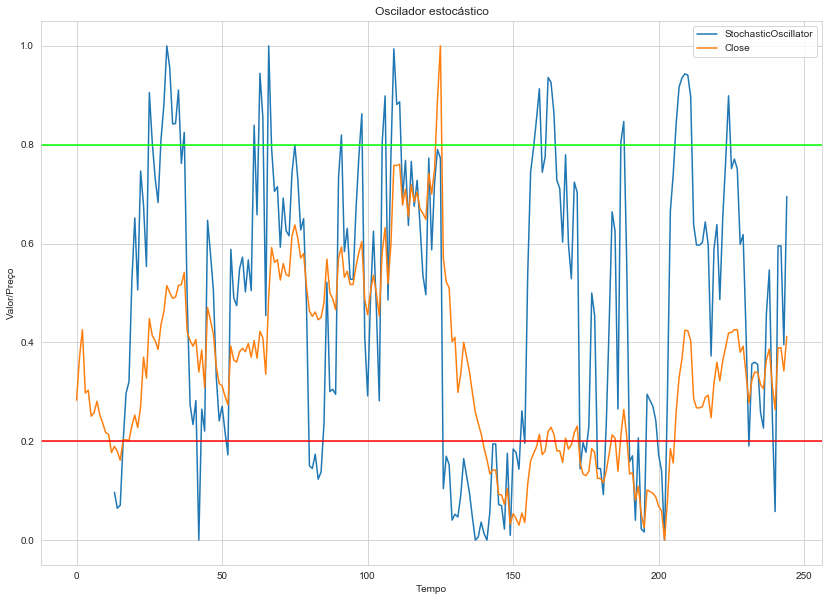

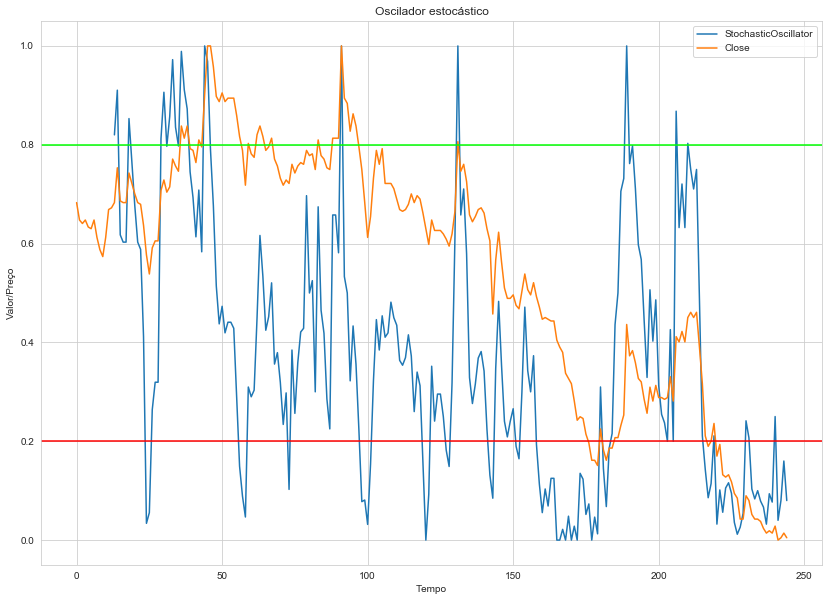

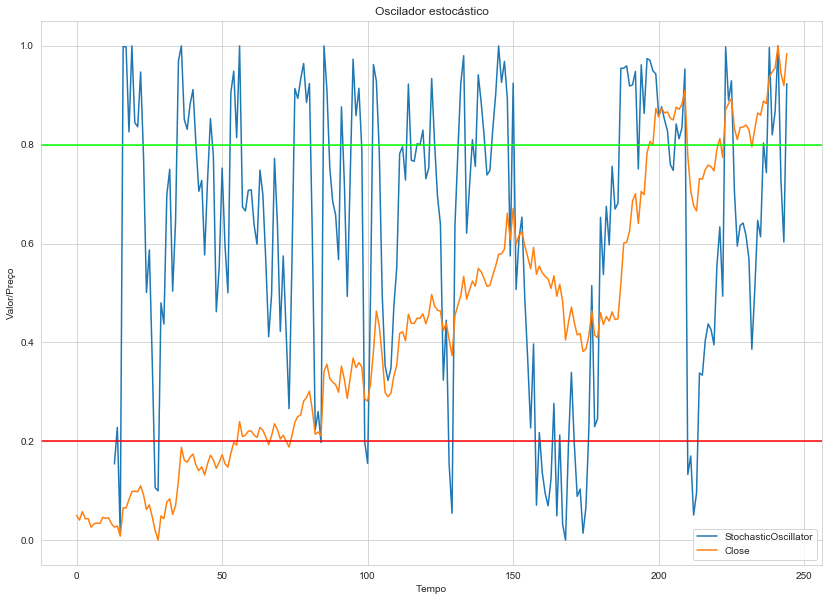

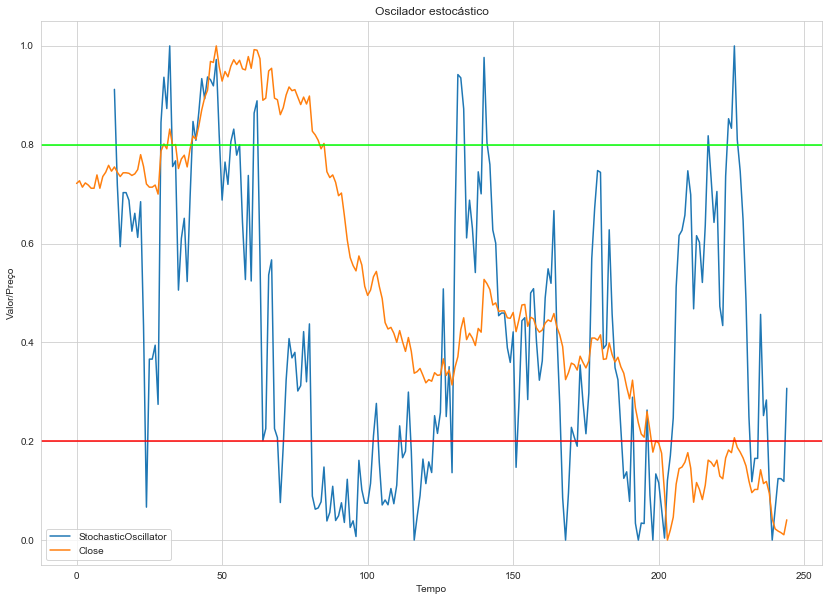

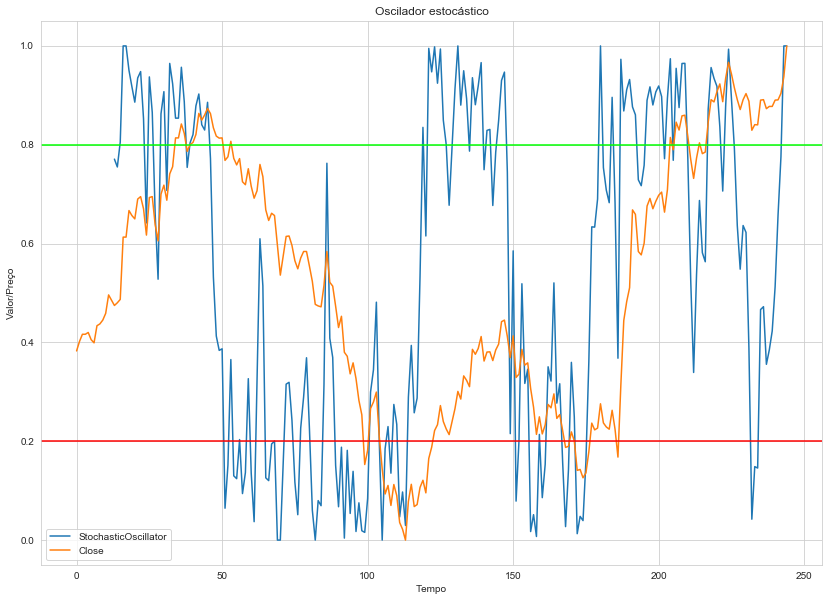

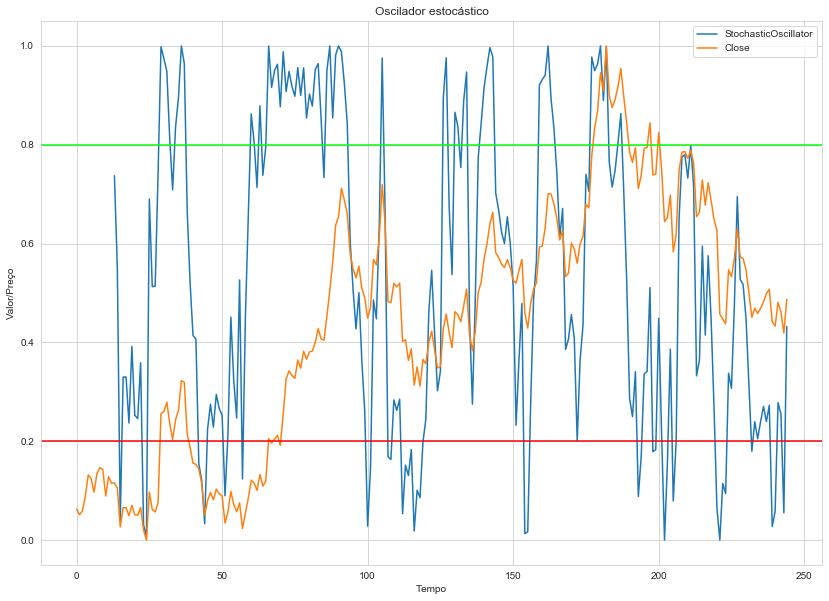

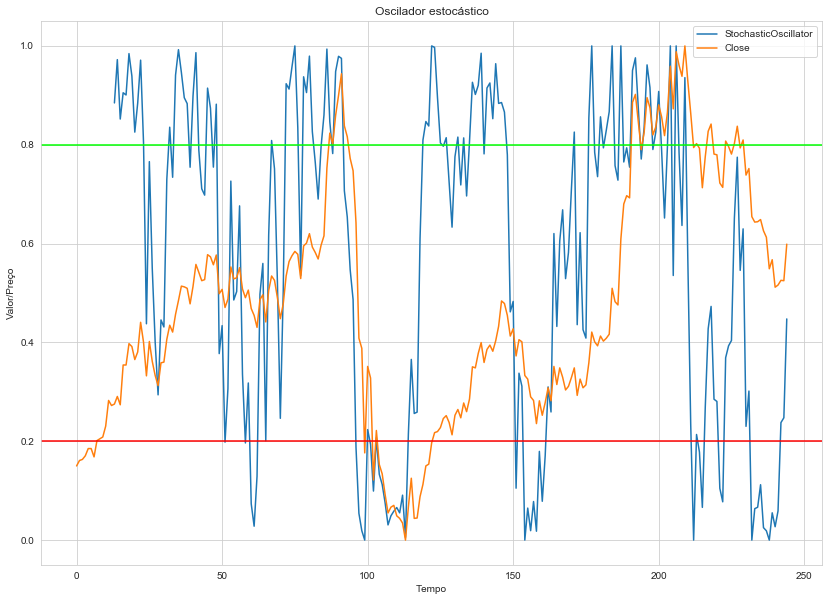

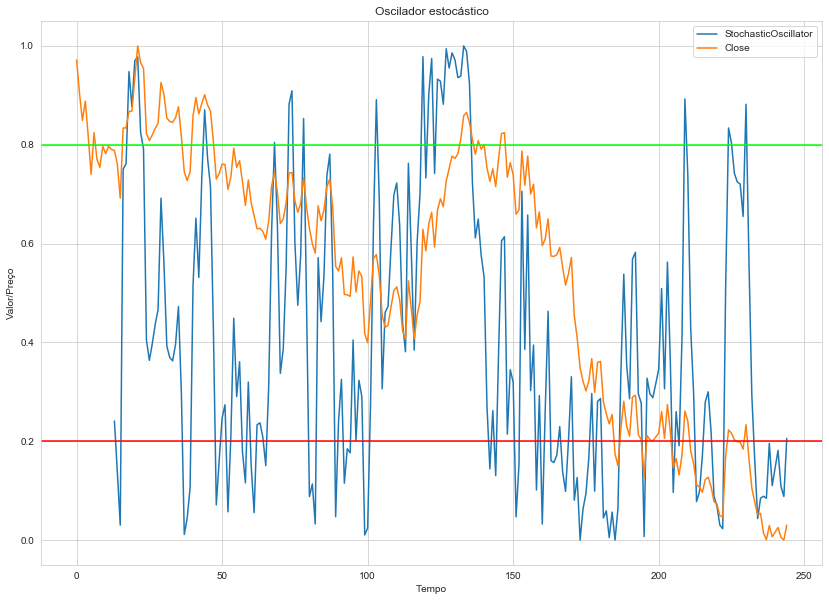

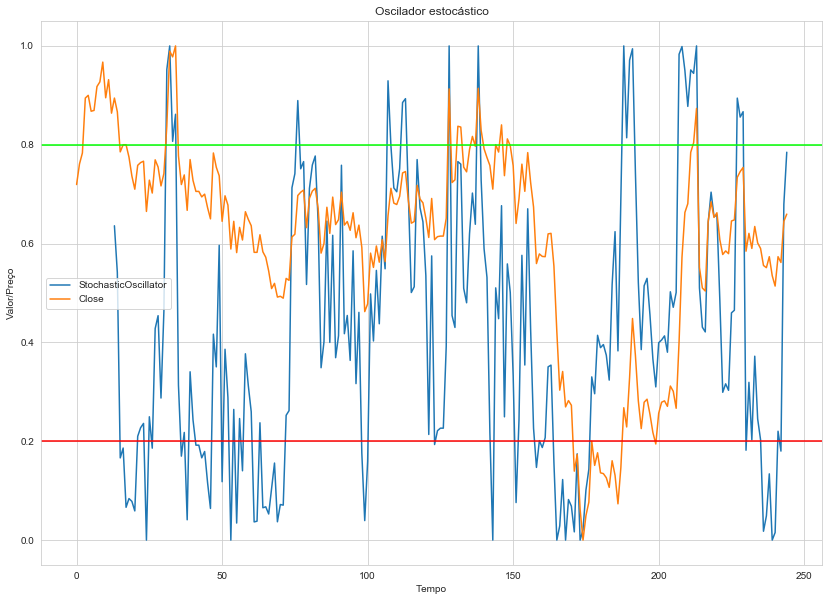

In [1170]:
plot_stochastic_oscillator_all_stocks(historicStock)

<h2><b>Function to plot correlation matrix</b></h2>

In [1171]:
def show_corr_matrix(stock, inflation=False):

    if inflation == False:
        corrMatrix = stock[["Close", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "LongEMA", "MACD", "MoneyFlowIndex"]].corr()
    else:
        corrMatrix = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD", "InflationMoneyFlowIndex"]].corr()


    plt.figure(figsize = (10,10))
    sns.heatmap(corrMatrix, cmap='RdYlGn', center=0, annot=True)
    plt.show()

In [1172]:
def show_corr_matrix_all_stocks(stocks, inflation=False):
    for stock in stocks:
        if inflation == False:
            corrMatrix = stock[["Close", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "LongEMA", "MACD", "MoneyFlowIndex"]].corr()
        else:
            corrMatrix = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD", "InflationMoneyFlowIndex"]].corr()


        plt.figure(figsize = (10,10))
        sns.heatmap(corrMatrix, cmap='RdYlGn', center=0, annot=True)
        plt.show()

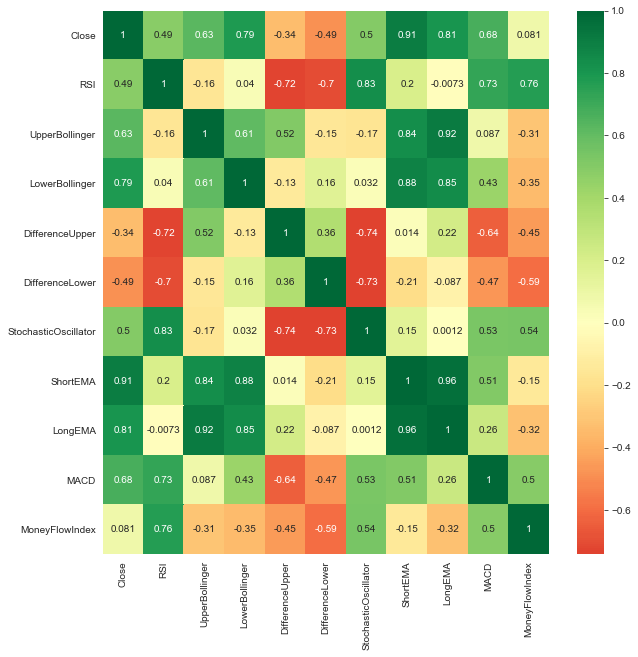

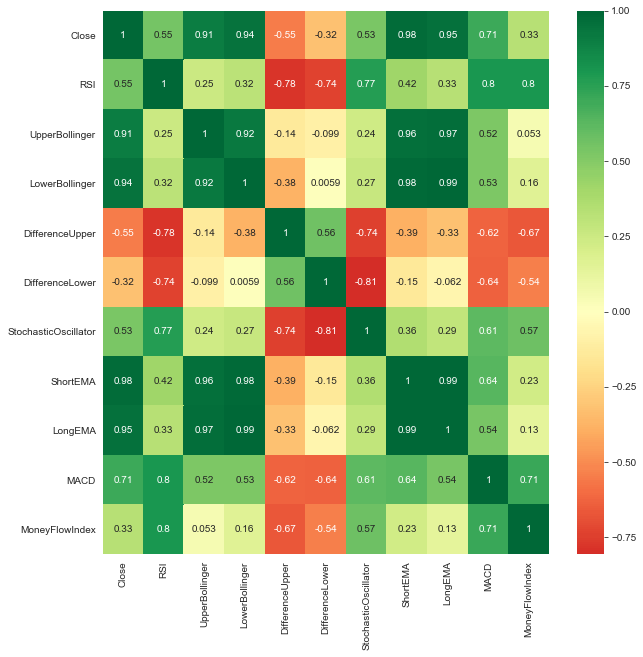

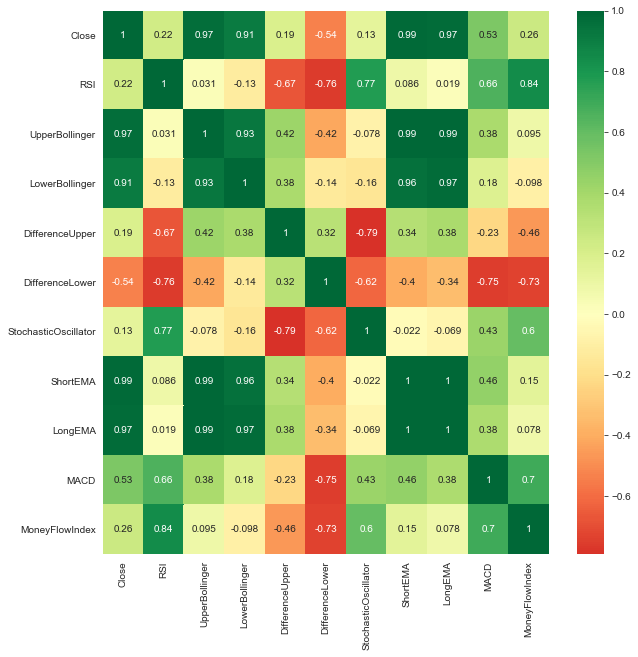

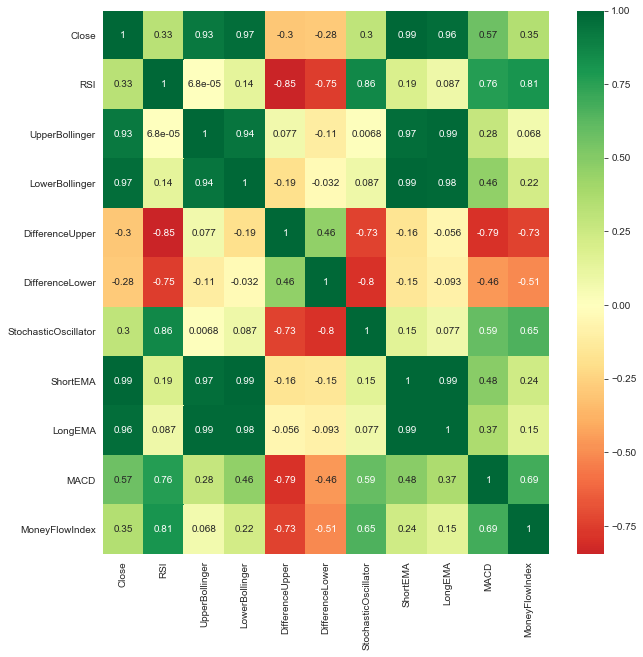

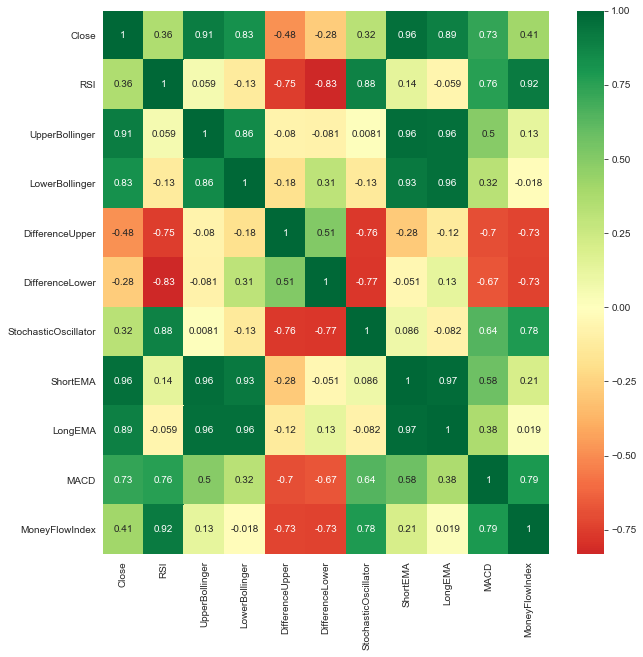

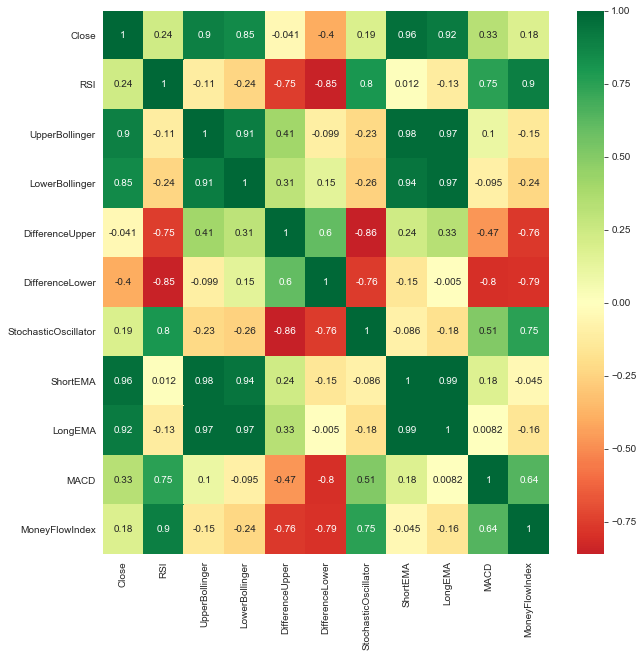

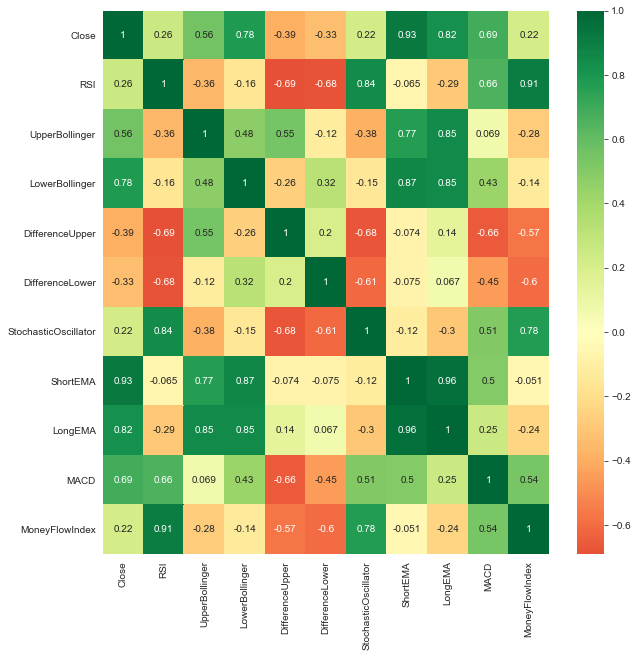

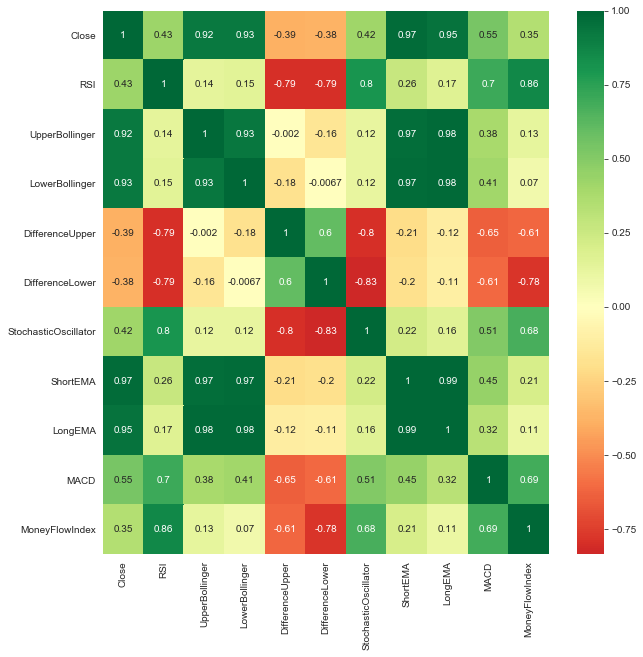

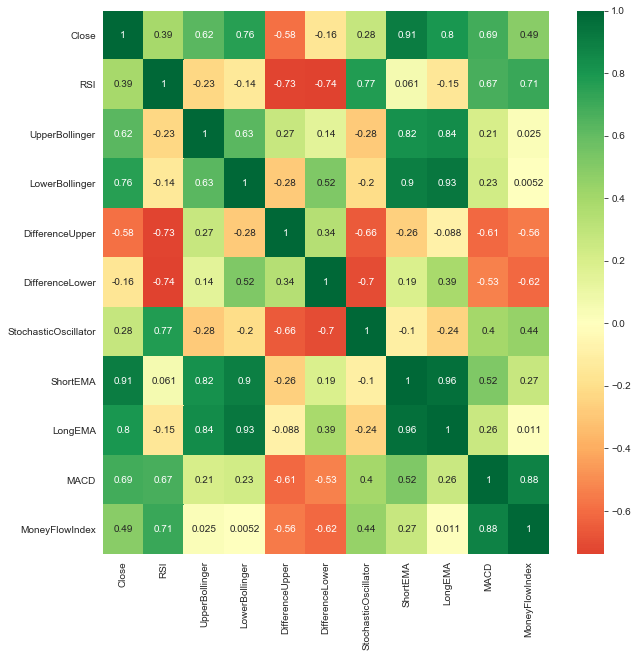

In [1173]:
show_corr_matrix_all_stocks(historicStock)

<h2><b>Function to predict traditional SVM</b></h2>

In [1072]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [1073]:
svmRegressorClose = svm.SVR(kernel="rbf")
svmRegressorNu = svm.NuSVR(kernel="rbf")

In [1074]:
def predict_svm_traditional_two_stocks(stock, stock2, inflation=False, feature='close'):
    if feature == 'close':
        print(stock2.shape)
        print(stock.shape)
        stock2 = stock2.rename(columns={"Close":"close","RSI": "rsi", "UpperBollinger": "upperbollinger", "LowerBollinger": "lowerbollinger", "DifferenceUpper": "differenceupper", "DifferenceLower": "differencelower", "StochasticOscillator": "stochasticoscillator", "ShortEMA": "shortema", "MACD": "macd", "Close": "close"})
        stock2X = stock2[["close","rsi", "upperbollinger", "lowerbollinger", "differenceupper", "differencelower", "stochasticoscillator", "shortema", "macd"]][30:]
        if inflation == False:
            stockX = stock[["Close","RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
            stockX = pd.concat([stockX, stock2X], axis=1)
            stockY = stock["Close"][30:]
        else:
            stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
            stockY = stock["InflationClose"][30:]
        X = np.array(stockX)
        y = np.array(stockY)
        X = X[:-5]
        y = y[5:]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
        
        parameters = {'C': [1, 10, 100], 'kernel': ('linear', 'rbf')}
        
        gssvm = GridSearchCV(svmRegressorClose, parameters)

        gssvm.fit(X_train, y_train)
        print(gssvm.best_params_)


        y_pred = gssvm.predict(X_test)

#         print('Coefficients: \n', svmRegressorClose.coef_)

        return y_pred, y_test, y_train

In [1075]:
def predict_svm_traditional(stock, inflation=False, feature='close'):
    if feature == 'close':
        if inflation == False:
            stockX = stock[["Close", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
            stockY = stock["Close"][30:]
        else:
            stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
            stockY = stock["InflationClose"][30:]
        X = np.array(stockX)
        y = np.array(stockY)
        X = X[:-5]
        y = y[5:]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
        
        parameters = {'C': [1, 10, 100], 'gamma': [0.001, 0.0001]}
        
        gssvm = GridSearchCV(svmRegressorClose, parameters)

        gssvm.fit(X_train, y_train)
        print(gssvm.best_params_)


        y_pred = gssvm.predict(X_test)

#         print('Coefficients: \n', svmRegressorClose.coef_)

        return y_pred, y_test, y_train

In [1076]:
def predict_plot_svm(stock, inflation=False, feature='close'):
    y_pred, y_test, y_train = predict_svm_traditional(stock, inflation, feature)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (10,8))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))
    
    plt.figure(figsize = (14,10))
    sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando SVM", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [1077]:
def predict_plot_svm_all_stocks(stocks, inflation=False, feature='close'):
    for stock in stocks:
        y_pred, y_test, y_train = predict_svm_traditional(stock, inflation, feature)

        y_pred = y_pred[5:]
        y_test = y_test[:-5]

        predictUpDown = upOrDownNpArray(y_pred)
        realUpDown = upOrDownNpArray(y_test)

        print(predictUpDown)
        print(realUpDown)

        i = 0
        count = 0

        plt.figure(figsize = (10,8))

        matrix = confusion_matrix(realUpDown, predictUpDown)
        sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)

        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.title('Matriz de confusão')
        plt.show()

        print('F1 score: ', f1_score(realUpDown, predictUpDown))
        print('Precision score: ', precision_score(realUpDown, predictUpDown))
        print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
        print('MAE score: ', mean_absolute_error(y_test, y_pred))
        print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
        print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
        print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))

        plt.figure(figsize = (14,10))
        sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
        plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
        plt.title("Predição da ação usando SVM", fontsize=18)
        plt.xlabel('Tempo', fontsize=14)
        plt.ylabel('Preço', fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

{'C': 100, 'gamma': 0.0001}
[0 0 1 1 0 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0
 0 0 0 1 0 1 1 0 0 0]
[0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1
 0 1 0 1 0 0 0 0 1 0]


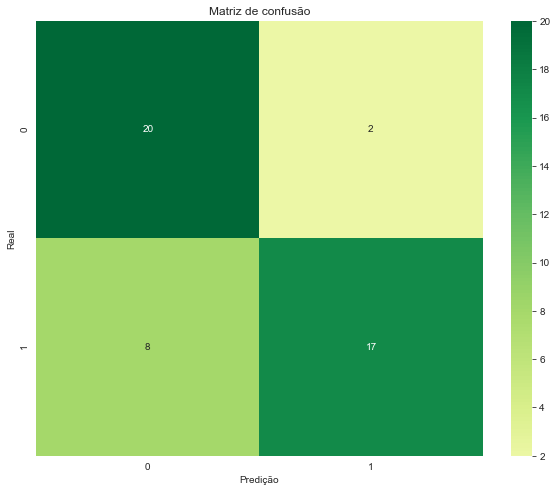

F1 score:  0.7727272727272727
Precision score:  0.8947368421052632
Accuracy score:  0.7872340425531915
MAE score:  1.3344877249831792
MSE value:  2.929382763766235
RMSE value:  1.711543970737017
MAPE value:  2.452411171741284


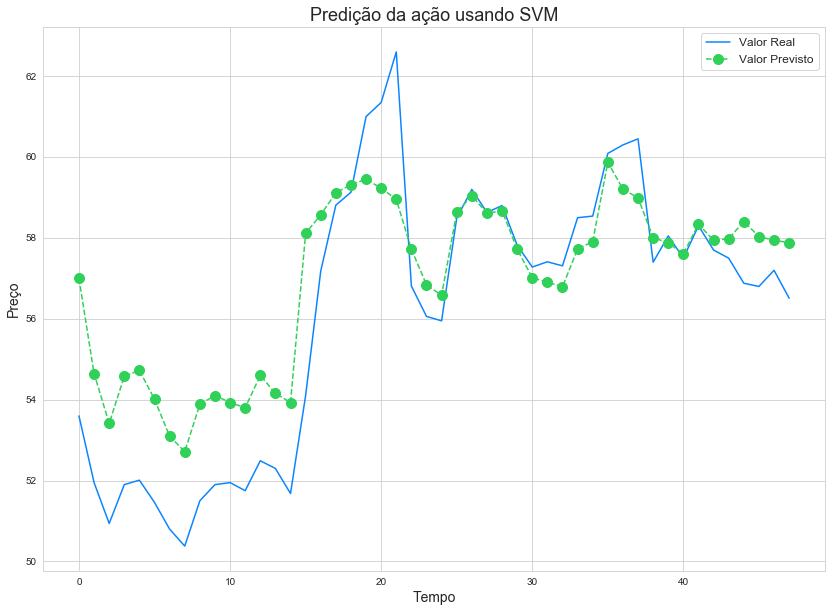

In [1079]:
predict_plot_svm(historicStock[8])

<h2><b>Function to predict Nu SVM</b></h2>

In [1116]:
def predict_svm_nu(stock, inflation=False):
    if inflation == False:
        stockX = stock[["Close", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
        stockY = stock["Close"][30:]
    else:
        stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
        stockY = stock["InflationClose"][30:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-5]
    y = y[5:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
    
    parameters = {'C': [1, 10, 100], 'nu': [0.1, 0.5, 1]}
    
    gssvm = GridSearchCV(svmRegressorNu, parameters)
    gssvm.fit(X_train, y_train)
    
    y_pred = gssvm.predict(X_test)
    
    print(gssvm.best_params_)

#     print('Coefficients: \n', svmRegressorNu.coef_)
    
    return y_pred, y_test, y_train

In [1117]:
def predict_plot_svm_nu(stock, inflation=False):
    y_pred, y_test, y_train = predict_svm_nu(stock)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (10,8))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))
    
    plt.figure(figsize = (14,10))
    sns.set_style("whitegrid")
    sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando Nu SVM", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [1118]:
def predict_plot_svm_nu_all_stocks(stocks, inflation=False):
    for stock in stocks:
        y_pred, y_test, y_train = predict_svm_nu(stock)

        y_pred = y_pred[5:]
        y_test = y_test[:-5]

        predictUpDown = upOrDownNpArray(y_pred)
        realUpDown = upOrDownNpArray(y_test)

        print(predictUpDown)
        print(realUpDown)

        i = 0
        count = 0

        plt.figure(figsize = (10,8))

        matrix = confusion_matrix(realUpDown, predictUpDown)
        sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)

        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.title('Matriz de confusão')
        plt.show()

        print('F1 score: ', f1_score(realUpDown, predictUpDown))
        print('Precision score: ', precision_score(realUpDown, predictUpDown))
        print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
        print('MAE score: ', mean_absolute_error(y_test, y_pred))
        print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
        print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
        print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))

        plt.figure(figsize = (14,10))
        sns.set_style("whitegrid")
        sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
        plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
        plt.title("Predição da ação usando Nu SVM", fontsize=18)
        plt.xlabel('Tempo', fontsize=14)
        plt.ylabel('Preço', fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

{'C': 100, 'nu': 0.5}
[0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 1
 0 0 1 1 1 0 1 1 1 0]
[1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1
 0 0 1 1 0 0 0 1 1 0]


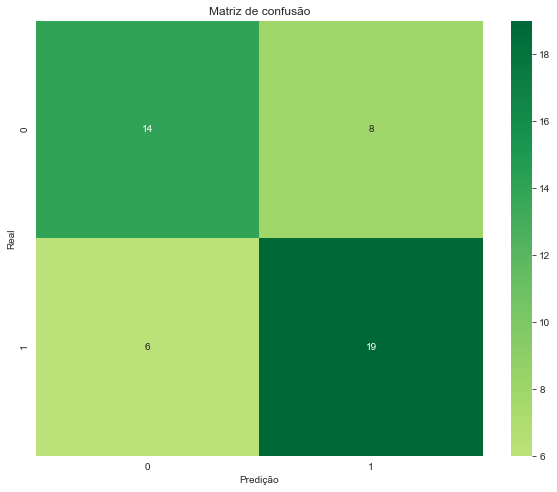

F1 score:  0.7307692307692308
Precision score:  0.7037037037037037
Accuracy score:  0.7021276595744681
MAE score:  0.3156146779916105
MSE value:  0.17200302371976225
RMSE value:  0.41473247246841216
MAPE value:  1.5833094559870693


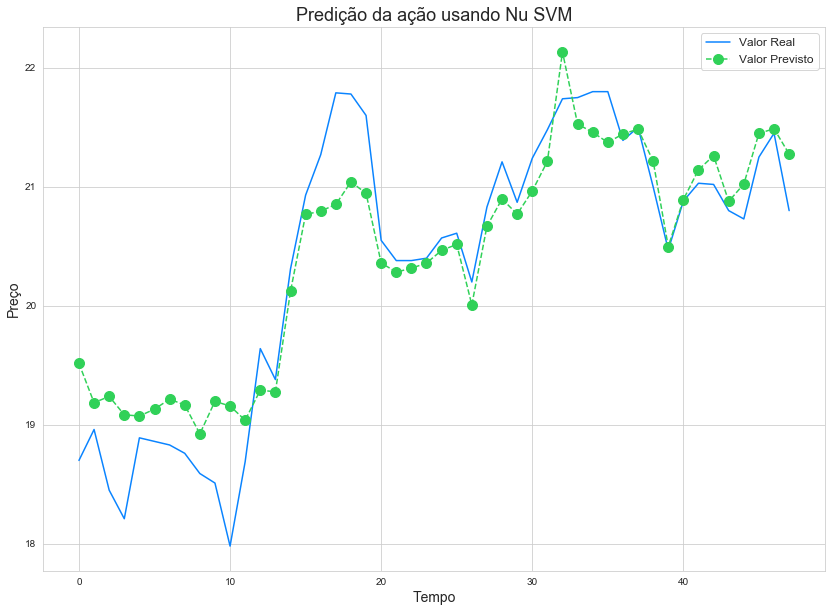

{'C': 100, 'nu': 1}
[0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 1 0]
[0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1
 1 0 0 0 1 0 0 0 1 0]


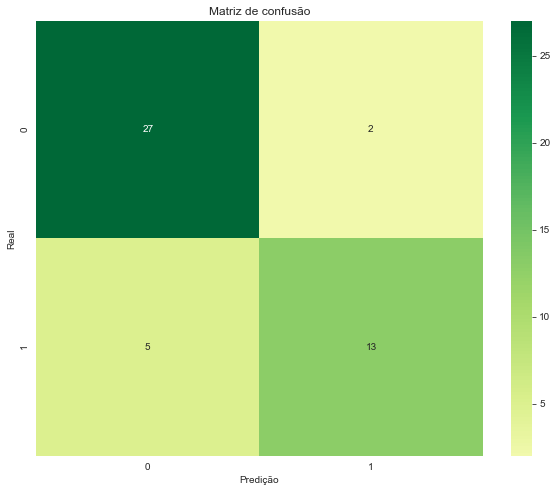

F1 score:  0.7878787878787877
Precision score:  0.8666666666666667
Accuracy score:  0.851063829787234
MAE score:  0.20156858867122254
MSE value:  0.0948274206588217
RMSE value:  0.3079406122271333
MAPE value:  10.352930223150599


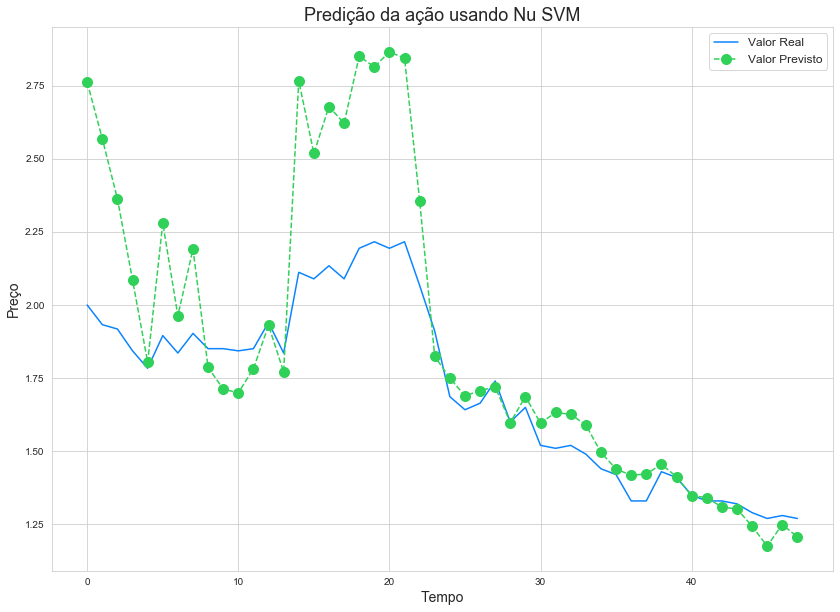

{'C': 100, 'nu': 1}
[0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0
 0 0 0 1 1 0 1 1 0 1]
[0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1
 1 0 0 1 1 0 1 0 1 1]


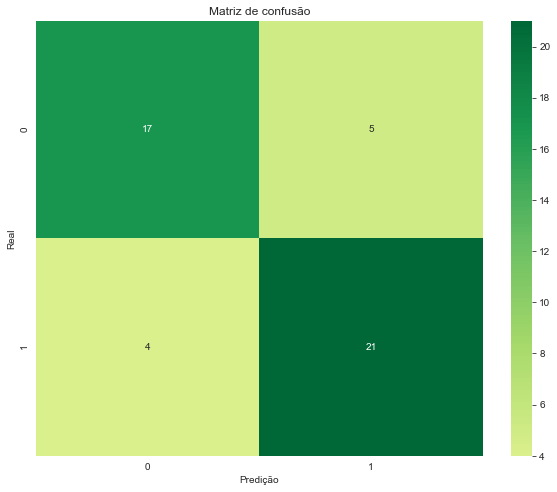

F1 score:  0.8235294117647058
Precision score:  0.8076923076923077
Accuracy score:  0.8085106382978723
MAE score:  0.19033652865850256
MSE value:  0.05391071320002059
RMSE value:  0.23218680668810748
MAPE value:  3.8381578076610903


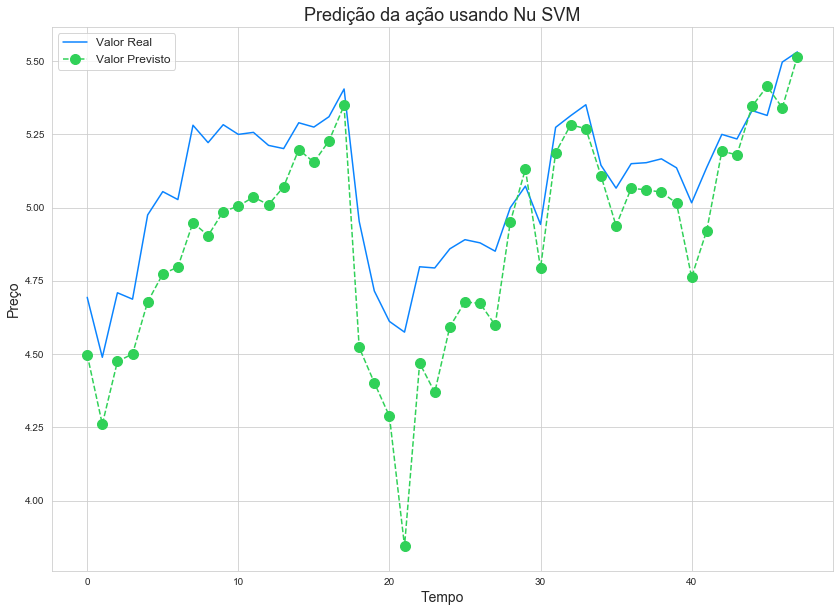

{'C': 100, 'nu': 0.5}
[0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 0
 0 1 1 0 0 0 1 0 1 0]
[0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0
 0 0 0 1 1 1 0 1 0 0]


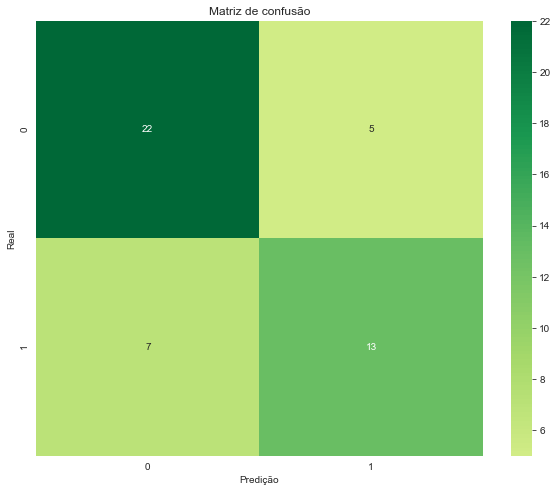

F1 score:  0.6842105263157895
Precision score:  0.7222222222222222
Accuracy score:  0.7446808510638298
MAE score:  0.45223259879214517
MSE value:  0.2902693548186608
RMSE value:  0.5387665123396783
MAPE value:  2.811230149812423


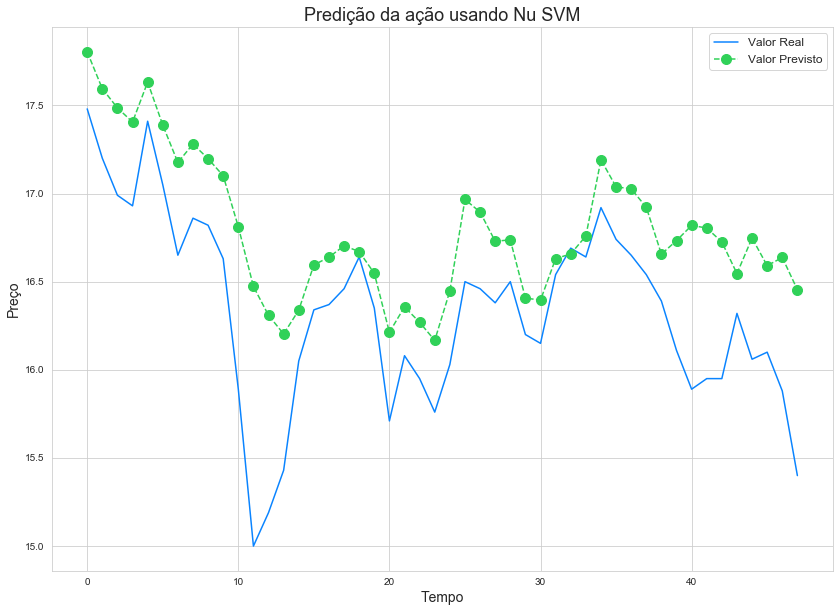

{'C': 100, 'nu': 1}
[1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1
 0 0 0 1 1 1 0 0 0 1]
[0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1
 1 0 0 1 0 1 1 0 1 1]


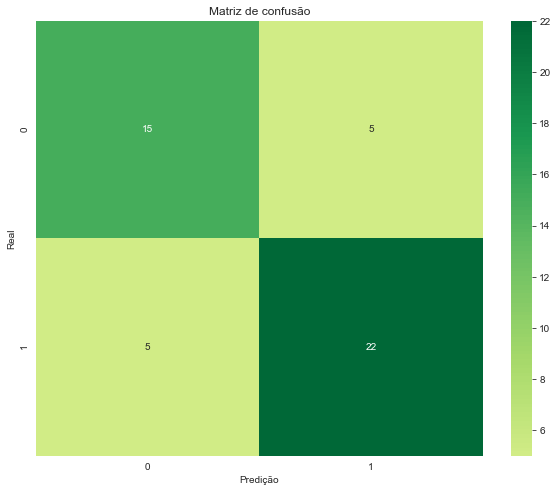

F1 score:  0.8148148148148148
Precision score:  0.8148148148148148
Accuracy score:  0.7872340425531915
MAE score:  0.7233928246899857
MSE value:  0.7420599984166018
RMSE value:  0.8614290443307573
MAPE value:  1.7138286542914813


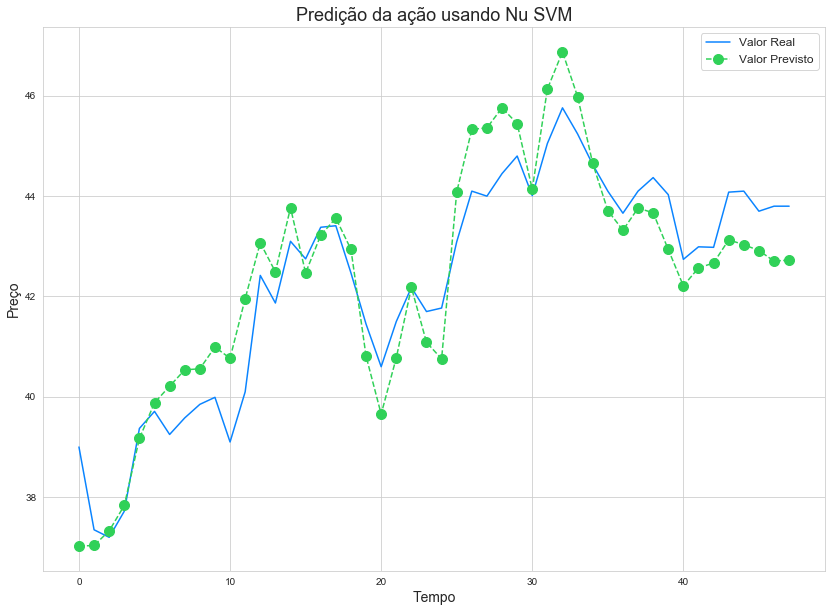

{'C': 100, 'nu': 0.1}
[0 1 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 0 1 1 1 0 0]
[0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 0 1 1 1 1 0]


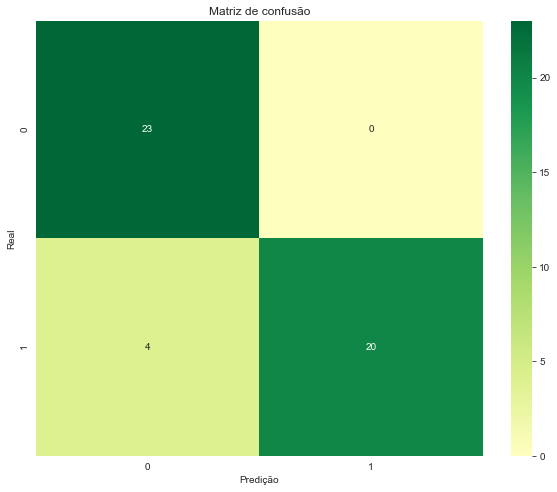

F1 score:  0.9090909090909091
Precision score:  1.0
Accuracy score:  0.9148936170212766
MAE score:  0.9224544285250635
MSE value:  1.1092130409991423
RMSE value:  1.0531918348521043
MAPE value:  1.7068454403375626


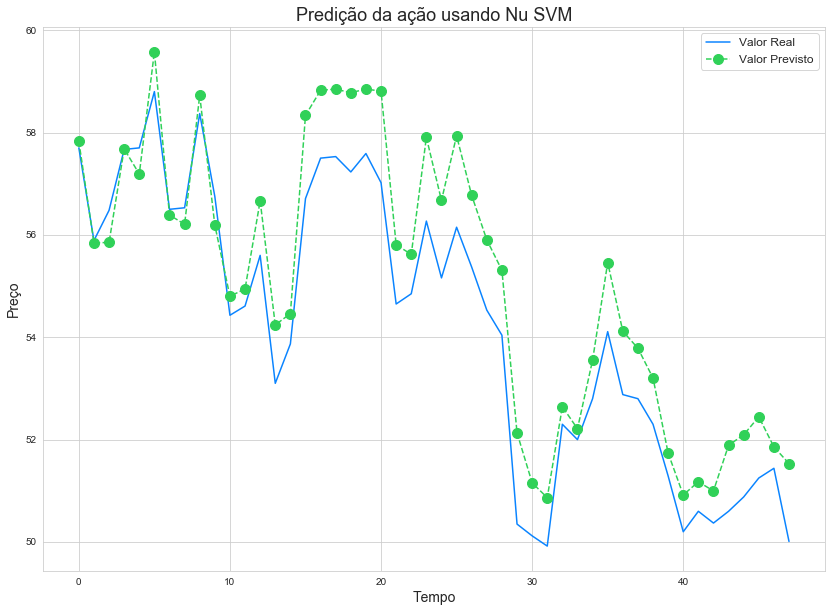

{'C': 100, 'nu': 1}
[0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 1 1 0 1 1 0 1
 0 1 0 1 0 0 0 1 0 1]
[0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1
 0 1 0 0 1 1 0 0 0 1]


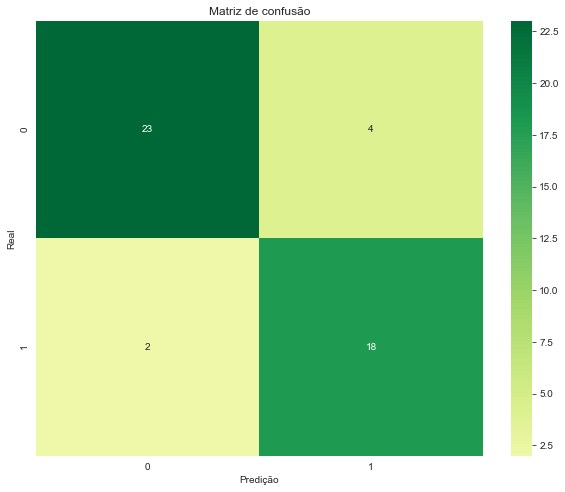

F1 score:  0.8571428571428572
Precision score:  0.8181818181818182
Accuracy score:  0.8723404255319149
MAE score:  3.31390579728467
MSE value:  11.697471317236074
RMSE value:  3.4201566217406
MAPE value:  13.03569548981768


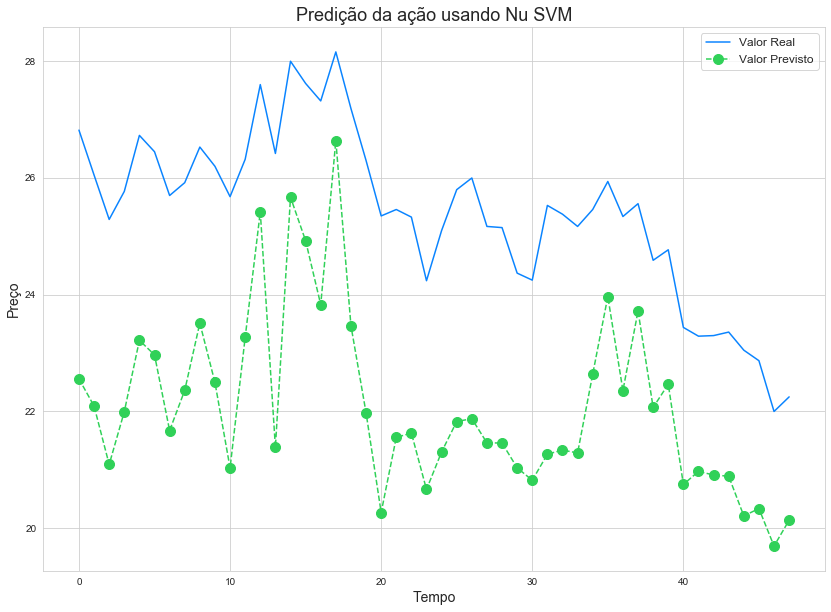

{'C': 100, 'nu': 0.5}
[0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0
 1 0 0 0 1 0 0 0 0 0]
[0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 0 0 1 0 0 1 0]


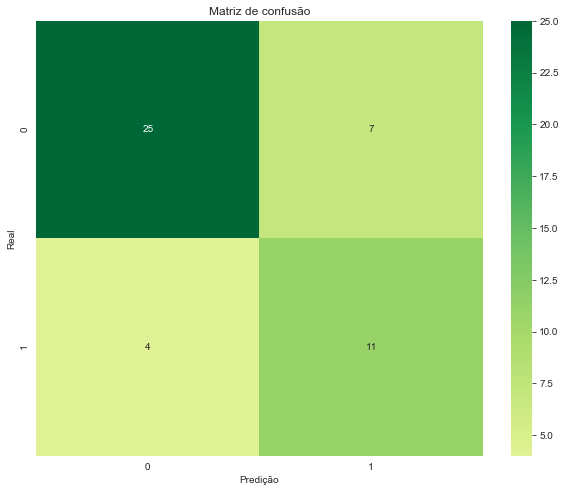

F1 score:  0.6666666666666666
Precision score:  0.6111111111111112
Accuracy score:  0.7659574468085106
MAE score:  1.15297075161367
MSE value:  2.183627113469807
RMSE value:  1.4777100911443377
MAPE value:  5.425551231871792


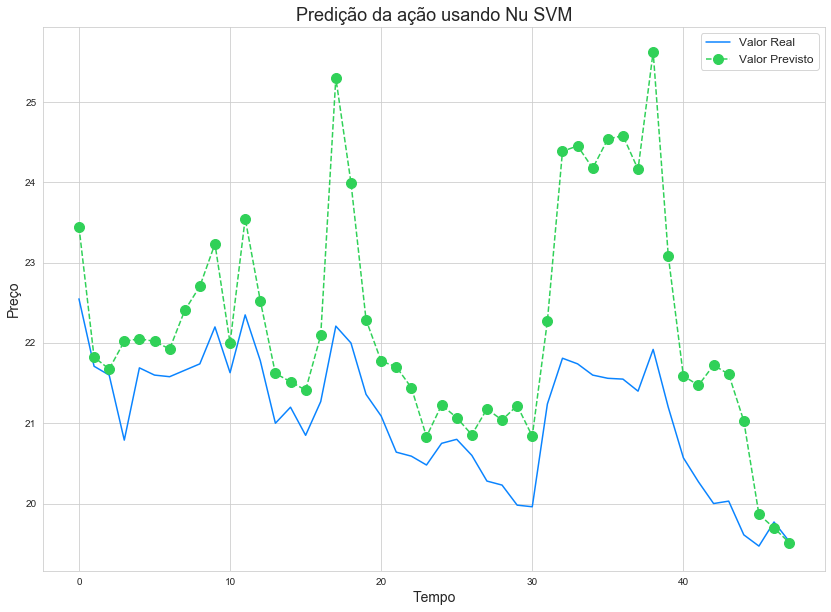

{'C': 100, 'nu': 0.5}
[0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0
 1 0 0 1 0 1 1 0 1 0]
[0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1
 0 1 0 1 0 0 0 0 1 0]


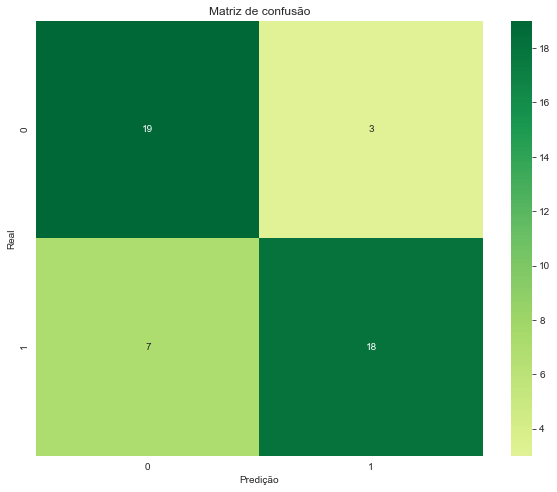

F1 score:  0.782608695652174
Precision score:  0.8571428571428571
Accuracy score:  0.7872340425531915
MAE score:  1.478454426742778
MSE value:  3.336247645597178
RMSE value:  1.826539801262808
MAPE value:  2.6904290744715453


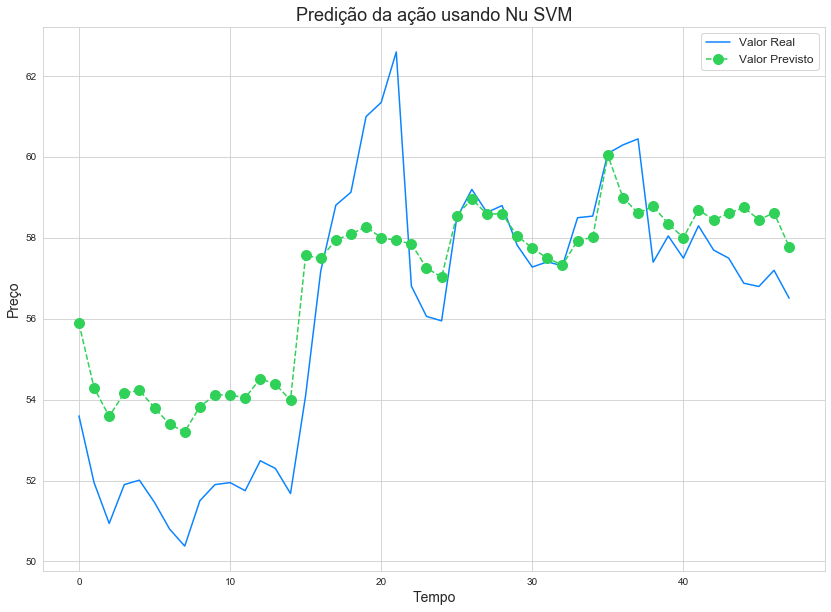

In [1119]:
predict_plot_svm_nu_all_stocks(historicStock)

<h2><b>Scaling data for LSTM</b></h2>

In [46]:
# scaler = MinMaxScaler()
# stockScaled = []
# stocksScaled = []

# for stock in historicStock:
#     stocksScaled.append(stock)
    
# for stock in stocksScaled:
#     stockScaled.append(pd.DataFrame(scaler.fit_transform(stock), columns=historicStock[0].columns))

In [47]:
# def predict_LSTM(stock, inflation=False):
#     if inflation == False:
#         stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
#         stockY = stock["Close"][30:]
#     else:
#         stockX = stock[["InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
#         stockY = stock["InflationClose"][15:]
#     X = np.array(stockX)
#     y = np.array(stockY)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
    
#     X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
#     X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
#     y_train = y_train.reshape(y_train.shape[0], 1, 1)
#     y_test = y_test.reshape(y_test.shape[0], 1, 1)
    
#     model = Sequential()

#     model.add(LSTM(128, activation='sigmoid', input_shape=(8,1)))
#     model.add(Dropout(0.2))
    
#     model.add(LSTM(128, activation='sigmoid'))
#     model.add(Dropout(0.2))
    
#     model.add(Dense(32, activation='sigmoid'))
#     model.add(Dropout(0.2))
    
#     model.add(Dense(10, activation='softmax'))
#     model.add(Dropout(0.2))
    
#     model.compile(optimizer=Adam(lr=1e-3, decay=1e-5), metrics=['accuracy'])
    
#     model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

In [48]:
# predict_LSTM(stockScaled[0])

<h2><b>Function to predict with Kernel Ridge Regression</b></h2>

In [1080]:
clf = KernelRidge(alpha=1.0, kernel='rbf')

In [1081]:
def predict_kernel_ridge(stock, inflation=False):
    if inflation == False:
        stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
        stockY = stock["Close"][30:]
    else:
        stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
        stockY = stock["InflationClose"][30:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-5]
    y = y[5:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
    
    parameters = {'alpha': [1, 0.1, 0.001], 'gamma': [None, 1, 0.1, 0.01, 0.001, 0.0001]}

    clf = KernelRidge(alpha=1.0)
    gssvm = GridSearchCV(clf, parameters, scoring = 'neg_mean_squared_error')
    gssvm.fit(X_train, y_train)
        
    y_pred = gssvm.predict(X_test)
    
    print(gssvm.best_params_)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (10,8))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))
    
    plt.figure(figsize = (14,10))
    sns.set_style("whitegrid")
    sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando Regressão Kernel Ridge", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [1082]:
def predict_kernel_ridge_all_stocks(stocks, inflation=False):
    for stock in stocks:
        if inflation == False:
            stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
            stockY = stock["Close"][30:]
        else:
            stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
            stockY = stock["InflationClose"][30:]
        X = np.array(stockX)
        y = np.array(stockY)
        X = X[:-5]
        y = y[5:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

        clf = KernelRidge(alpha=0)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        y_pred = y_pred[5:]
        y_test = y_test[:-5]

        predictUpDown = upOrDownNpArray(y_pred)
        realUpDown = upOrDownNpArray(y_test)

        print(predictUpDown)
        print(realUpDown)

        i = 0
        count = 0

        plt.figure(figsize = (10,8))

        matrix = confusion_matrix(realUpDown, predictUpDown)
        sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)

        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.title('Matriz de confusão')
        plt.show()

        print('F1 score: ', f1_score(realUpDown, predictUpDown))
        print('Precision score: ', precision_score(realUpDown, predictUpDown))
        print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
        print('MAE score: ', mean_absolute_error(y_test, y_pred))
        print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
        print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
        print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))

        plt.figure(figsize = (14,10))
        sns.set_style("whitegrid")
        sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
        plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
        plt.title("Predição da ação usando Regressão Kernel Ridge", fontsize=18)
        plt.xlabel('Tempo', fontsize=14)
        plt.ylabel('Preço', fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

[1 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 1
 0 0 1 1 1 0 0 1 1 0]
[1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1
 0 0 1 1 0 0 0 1 1 0]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


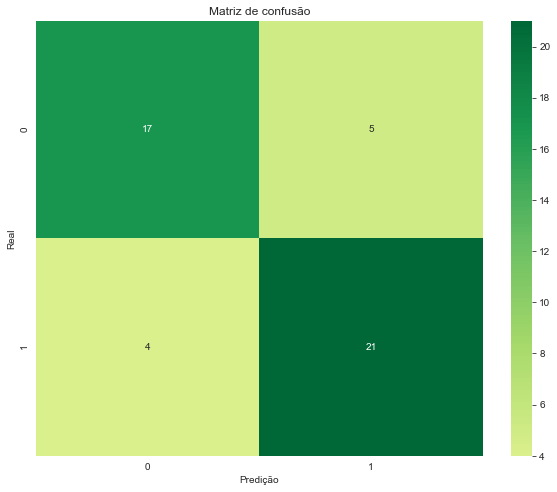

F1 score:  0.8235294117647058
Precision score:  0.8076923076923077
Accuracy score:  0.8085106382978723
MAE score:  0.49388917287190753
MSE value:  0.4276459800947426
RMSE value:  0.6539464657712759
MAPE value:  2.3775702297859866


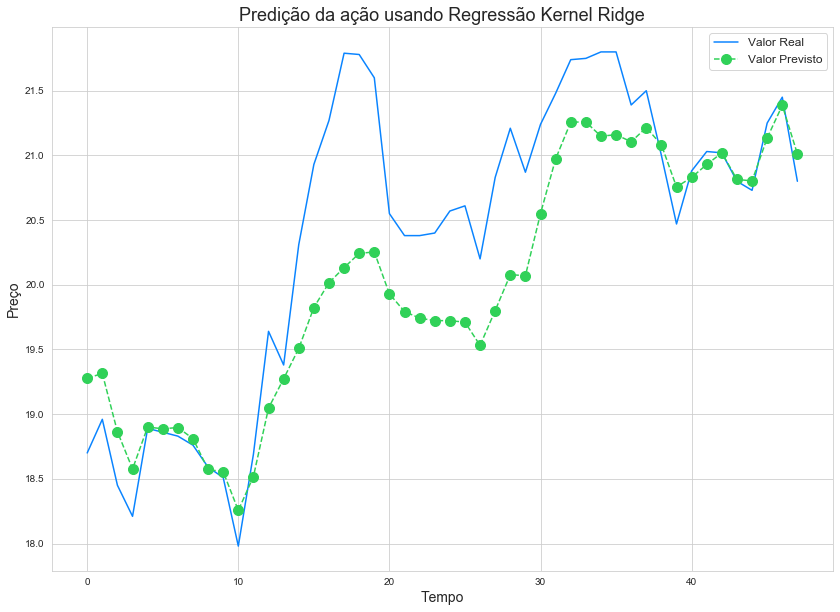

[0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 1 0 1 0 1 0]
[0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1
 1 0 0 0 1 0 0 0 1 0]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


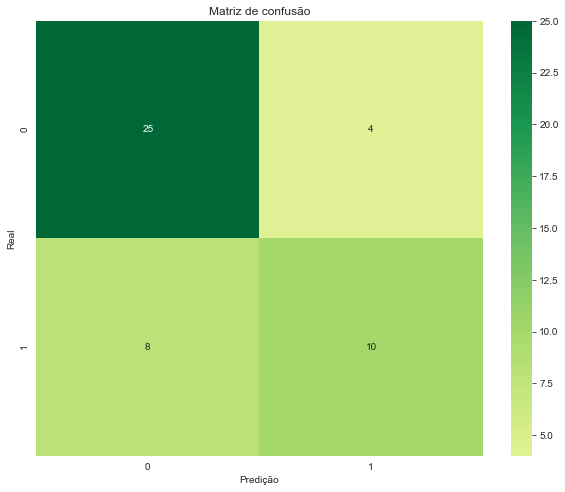

F1 score:  0.6250000000000001
Precision score:  0.7142857142857143
Accuracy score:  0.7446808510638298
MAE score:  0.09053894380728404
MSE value:  0.015580399244339441
RMSE value:  0.1248214694847783
MAPE value:  5.061359226158007


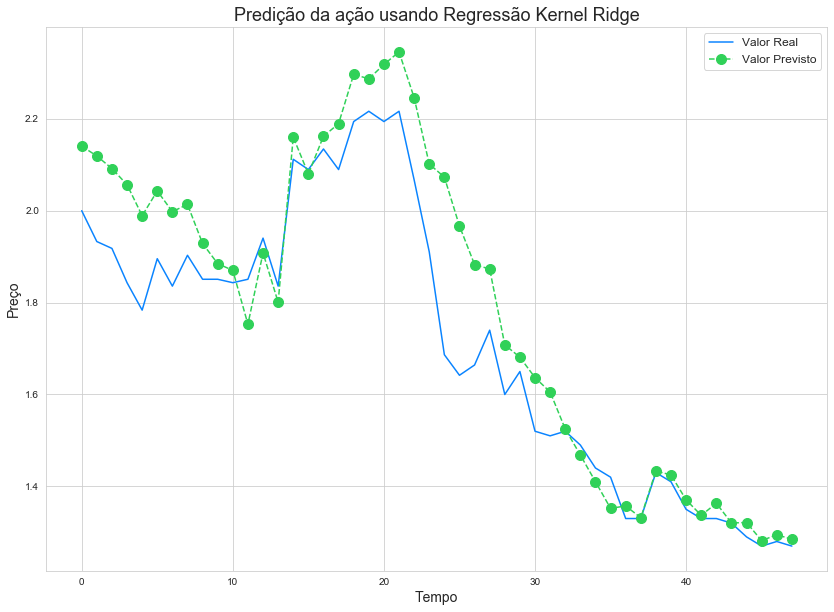

[1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 1 1 1 1 1 0]
[0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1
 1 0 0 1 1 0 1 0 1 1]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


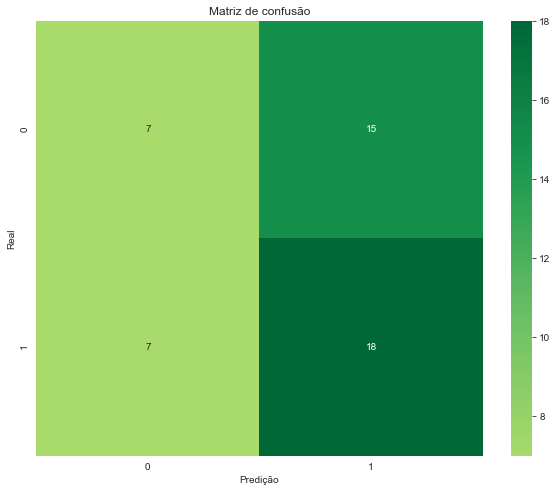

F1 score:  0.6206896551724138
Precision score:  0.5454545454545454
Accuracy score:  0.5319148936170213
MAE score:  0.32235092918078107
MSE value:  0.13802857360901064
RMSE value:  0.37152196921448755
MAPE value:  6.33503978686419


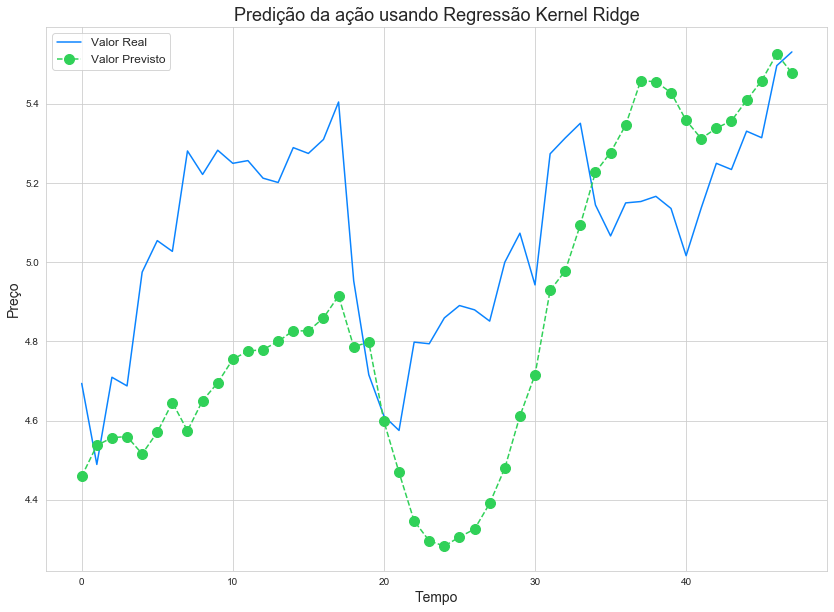

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 0
 0 0 0 0 0 1 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0
 0 0 0 1 1 1 0 1 0 0]


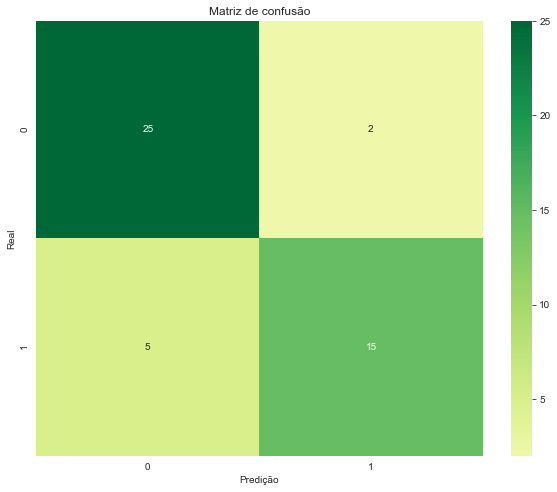

F1 score:  0.8108108108108107
Precision score:  0.8823529411764706
Accuracy score:  0.851063829787234
MAE score:  0.2697378794352214
MSE value:  0.08894878225639029
RMSE value:  0.2982428243166804
MAPE value:  1.6442864283054626


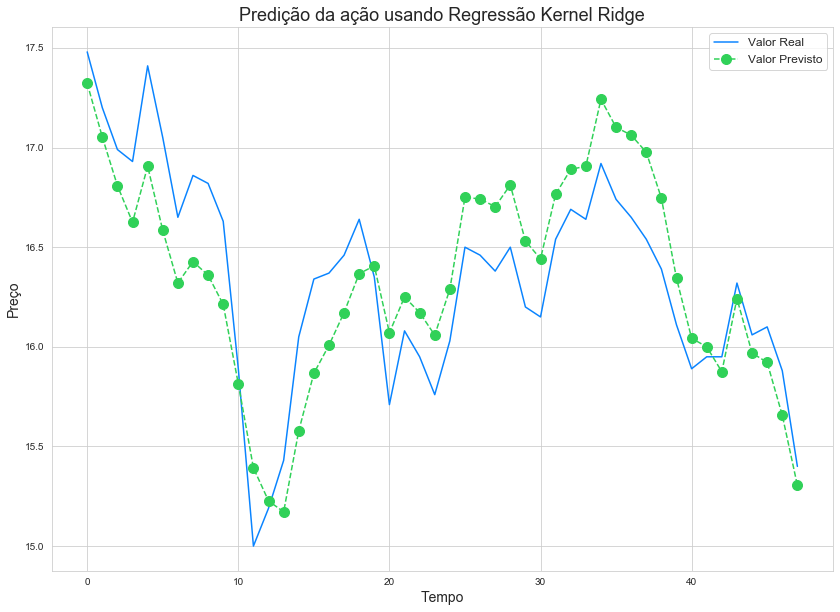

[1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1
 1 0 0 0 0 1 1 0 1 1]
[0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1
 1 0 0 1 0 1 1 0 1 1]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


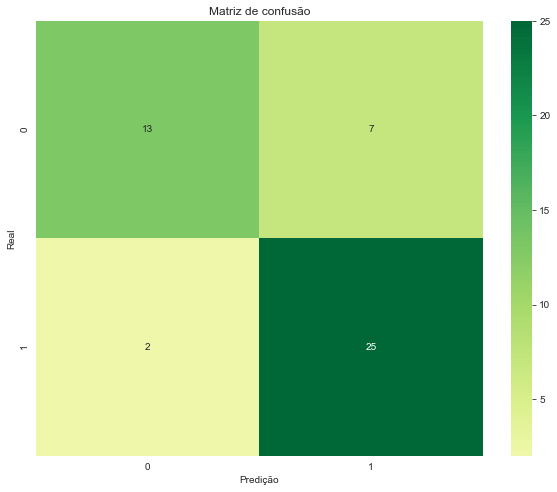

F1 score:  0.847457627118644
Precision score:  0.78125
Accuracy score:  0.8085106382978723
MAE score:  0.9447265466054281
MSE value:  1.2507205280953713
RMSE value:  1.118356172288315
MAPE value:  2.2161673764797785


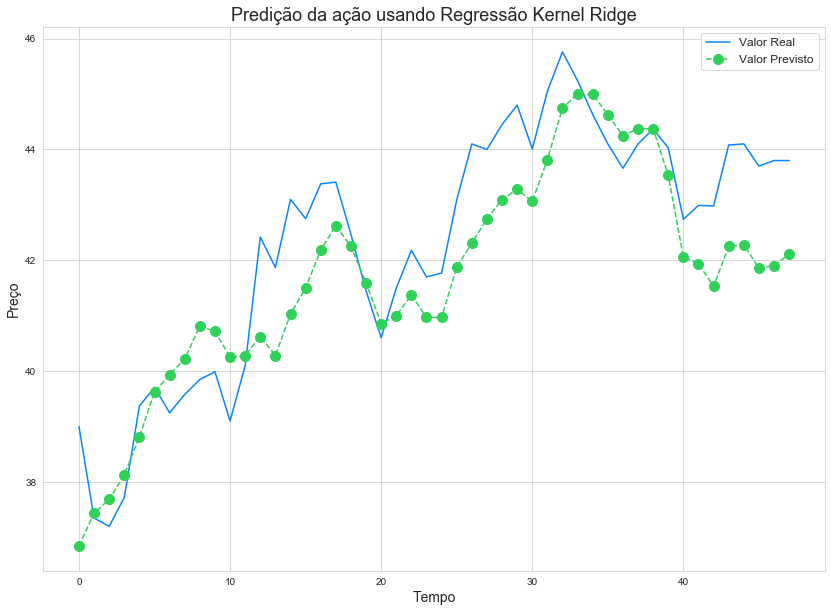

[0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 0 1 1 1 0 0]
[0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 0 1 1 1 1 0]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


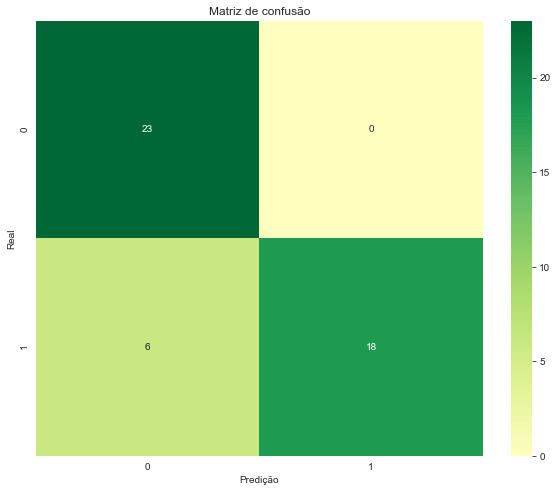

F1 score:  0.8571428571428571
Precision score:  1.0
Accuracy score:  0.8723404255319149
MAE score:  1.022379954655965
MSE value:  1.5255749130249872
RMSE value:  1.2351416570681224
MAPE value:  1.899423997515305


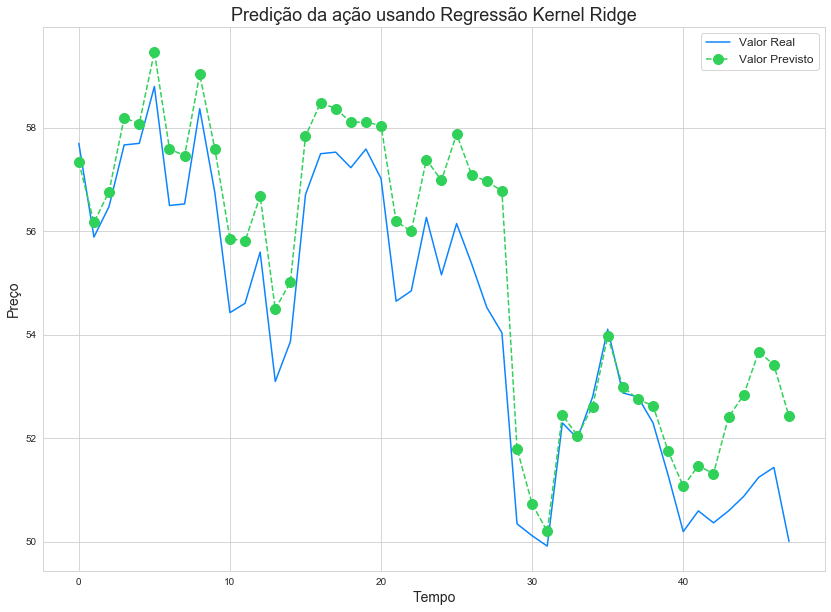

[0 0 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1
 0 0 0 1 1 1 0 0 0 1]
[0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1
 0 1 0 0 1 1 0 0 0 1]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


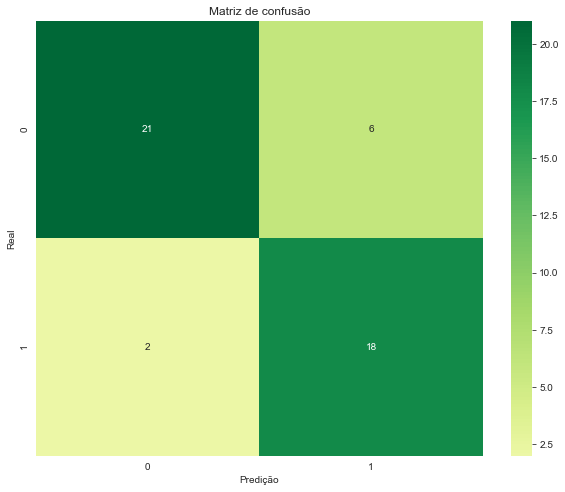

F1 score:  0.8181818181818182
Precision score:  0.75
Accuracy score:  0.8297872340425532
MAE score:  2.4395264784495034
MSE value:  11.978930405910129
RMSE value:  3.461059145104303
MAPE value:  9.356066261458707


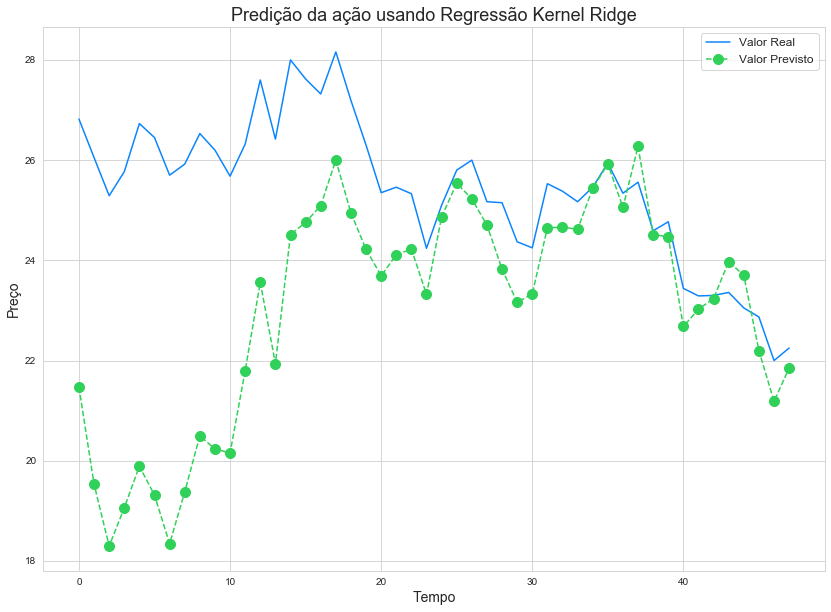

[0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 0 0 1 0 0 1 0]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


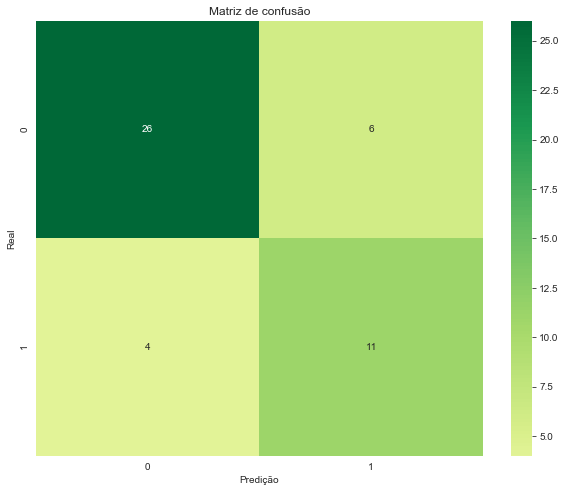

F1 score:  0.6875
Precision score:  0.6470588235294118
Accuracy score:  0.7872340425531915
MAE score:  0.3969757954279582
MSE value:  0.2252899601548203
RMSE value:  0.4746471954566047
MAPE value:  1.8843750691782135


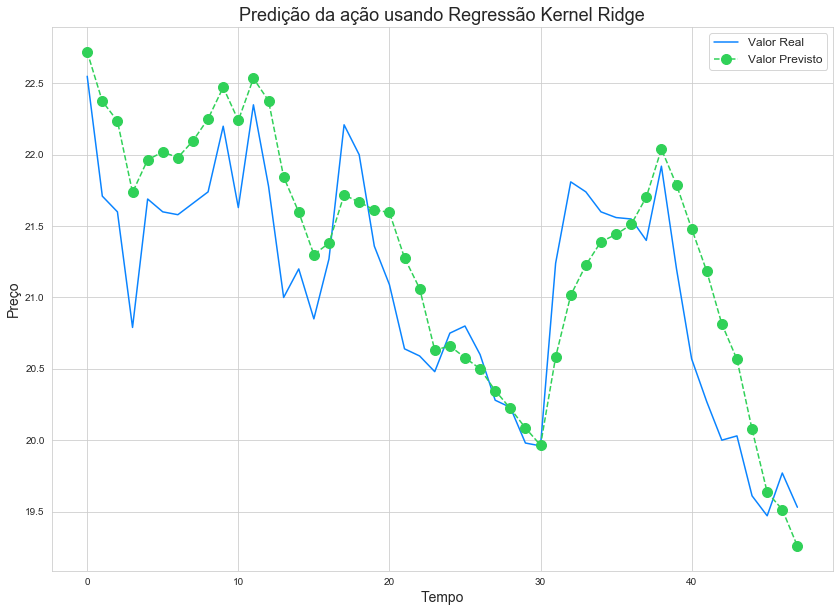

[0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1
 0 1 1 1 0 0 0 0 1 0]
[0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1
 0 1 0 1 0 0 0 0 1 0]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


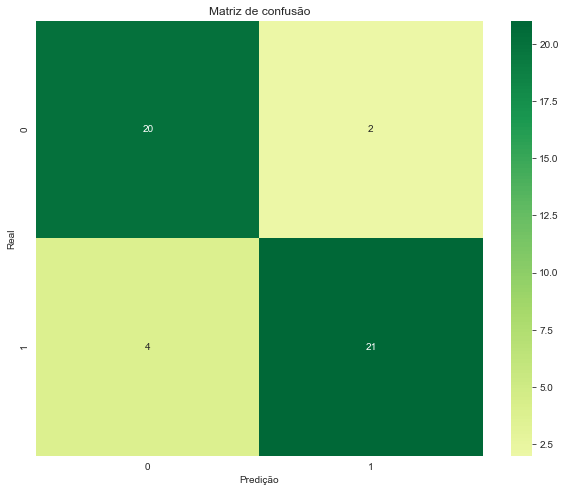

F1 score:  0.8749999999999999
Precision score:  0.9130434782608695
Accuracy score:  0.8723404255319149
MAE score:  2.2724767525990806
MSE value:  7.137714212908577
RMSE value:  2.6716500917800925
MAPE value:  3.9362989586389445


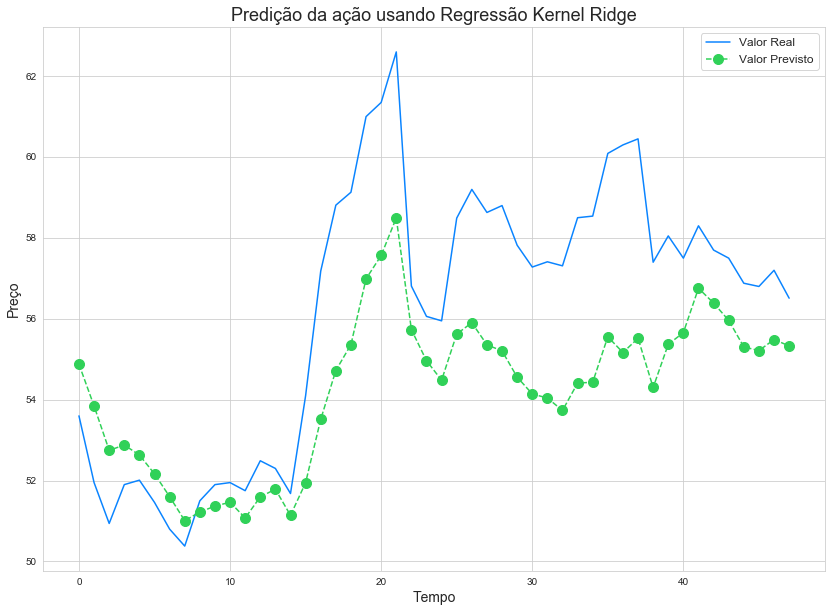

In [1083]:
predict_kernel_ridge_all_stocks(historicStock)

<h2><b>Function to predict with Linear Regression</b></h2>

In [1085]:
regr = linear_model.LinearRegression()

In [1086]:
def predict_linear(stock, stock2, inflation=False):
    print(stock2.shape)
    print(stock.shape)
    stock2 = stock2.rename(columns={"RSI": "rsi", "UpperBollinger": "upperbollinger", "LowerBollinger": "lowerbollinger", "DifferenceUpper": "differenceupper", "DifferenceLower": "differencelower", "StochasticOscillator": "stochasticoscillator", "ShortEMA": "shortema", "MACD": "macd", "Close": "close"})
    stock2X = stock2[["rsi", "upperbollinger", "lowerbollinger", "differenceupper", "differencelower", "stochasticoscillator", "shortema", "macd"]][30:]
    if inflation == False:
        stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
        stockX = pd.concat([stockX, stock2X], axis=1)
        stockY = stock["Close"][30:]
    else:
        stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
        stockY = stock["InflationClose"][30:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-5]
    y = y[5:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

    regr.fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (10,8))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
#     print('Coefficients: \n', regr.coef_)
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))
    
    plt.figure(figsize = (14,10))
    sns.set_style("whitegrid")
    sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando Regressão Linear", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [1087]:
def predict_linear(stock, inflation=False):
    if inflation == False:
        stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
        stockY = stock["Close"][30:]
    else:
        stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
        stockY = stock["InflationClose"][30:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-5]
    y = y[5:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

    regr.fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (10,8))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
#     print('Coefficients: \n', regr.coef_)
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))
    
    plt.figure(figsize = (14,10))
    sns.set_style("whitegrid")
    sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando Regressão Linear", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [1088]:
def predict_linear_all_stocks(stocks, inflation=False):
    for stock in stocks:
        if inflation == False:
            stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
            stockY = stock["Close"][30:]
        else:
            stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
            stockY = stock["InflationClose"][30:]
        X = np.array(stockX)
        y = np.array(stockY)
        X = X[:-5]
        y = y[5:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

        regr.fit(X_train, y_train)

        y_pred = regr.predict(X_test)

        y_pred = y_pred[5:]
        y_test = y_test[:-5]

        predictUpDown = upOrDownNpArray(y_pred)
        realUpDown = upOrDownNpArray(y_test)

        print(predictUpDown)
        print(realUpDown)

        i = 0
        count = 0

        plt.figure(figsize = (10,8))

        matrix = confusion_matrix(realUpDown, predictUpDown)
        sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)

        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.title('Matriz de confusão')
        plt.show()

    #     print('Coefficients: \n', regr.coef_)

        print('F1 score: ', f1_score(realUpDown, predictUpDown))
        print('Precision score: ', precision_score(realUpDown, predictUpDown))
        print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
        print('MAE score: ', mean_absolute_error(y_test, y_pred))
        print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
        print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
        print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))

        plt.figure(figsize = (14,10))
        sns.set_style("whitegrid")
        sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
        plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
        plt.title("Predição da ação usando Regressão Linear", fontsize=18)
        plt.xlabel('Tempo', fontsize=14)
        plt.ylabel('Preço', fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

[1 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1
 0 0 1 1 1 0 1 1 1 0]
[1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1
 0 0 1 1 0 0 0 1 1 0]


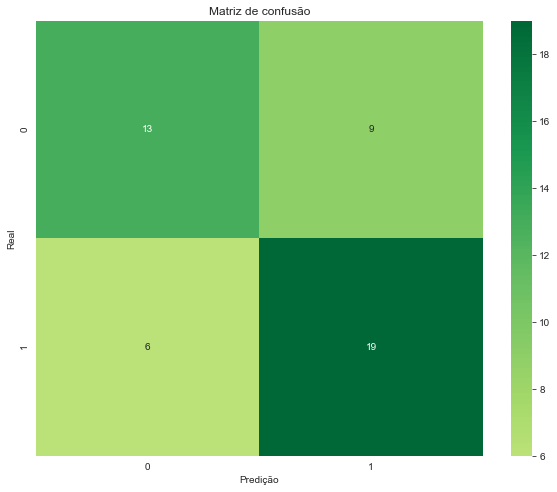

F1 score:  0.7169811320754718
Precision score:  0.6785714285714286
Accuracy score:  0.6808510638297872
MAE score:  0.4583549894345033
MSE value:  0.36263943778500707
RMSE value:  0.6021955145839324
MAPE value:  2.215914290742867


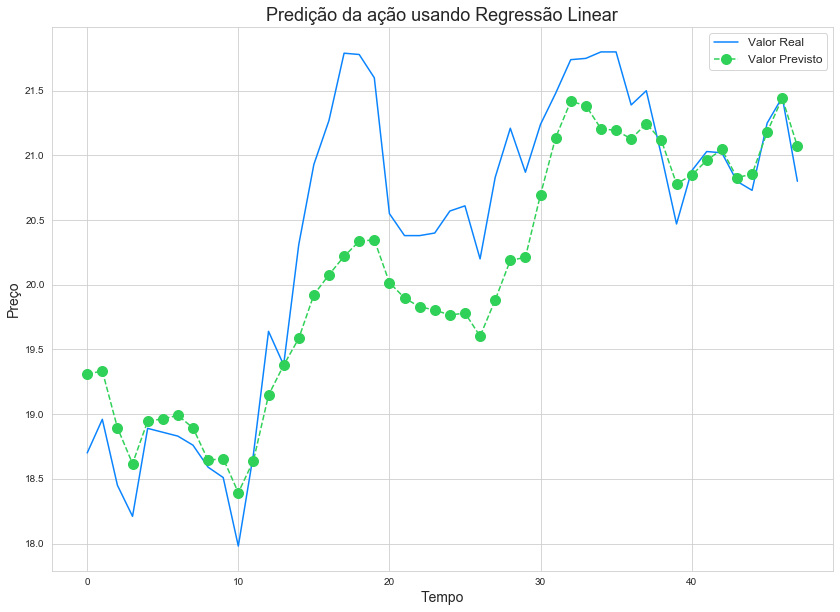

[0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 1 0 1 0 1 0]
[0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1
 1 0 0 0 1 0 0 0 1 0]


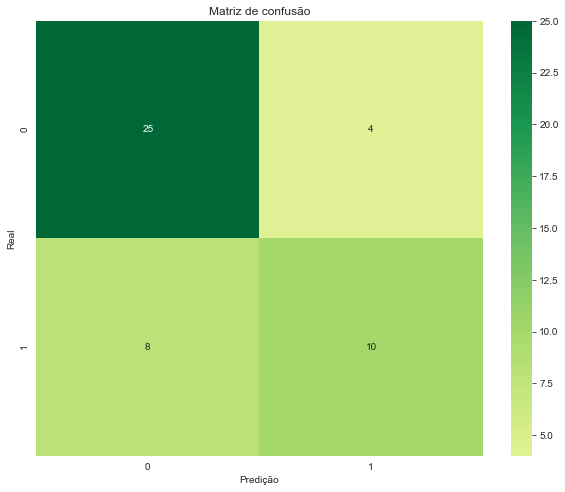

F1 score:  0.6250000000000001
Precision score:  0.7142857142857143
Accuracy score:  0.7446808510638298
MAE score:  0.08448082920516299
MSE value:  0.014133589959177609
RMSE value:  0.1188847759773202
MAPE value:  4.721262403970497


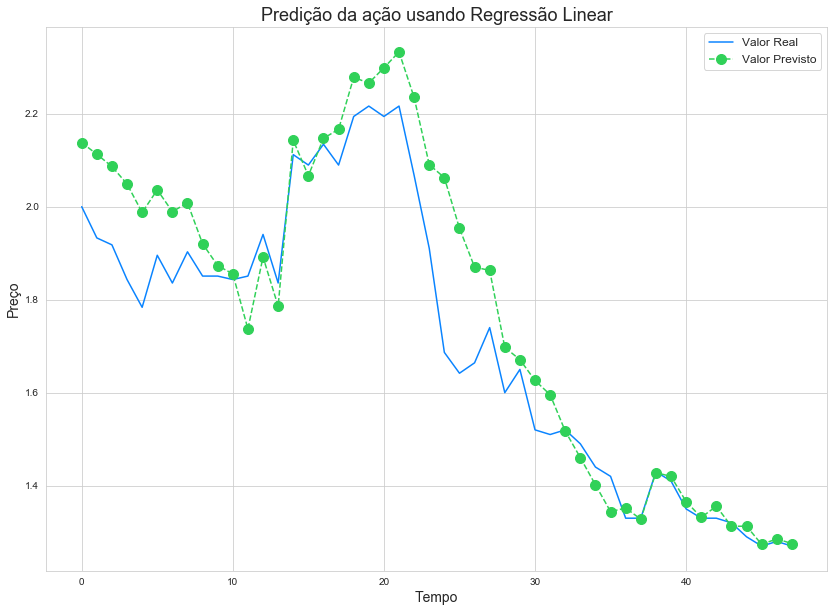

[1 1 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 1 1 0 1 1 0]
[0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1
 1 0 0 1 1 0 1 0 1 1]


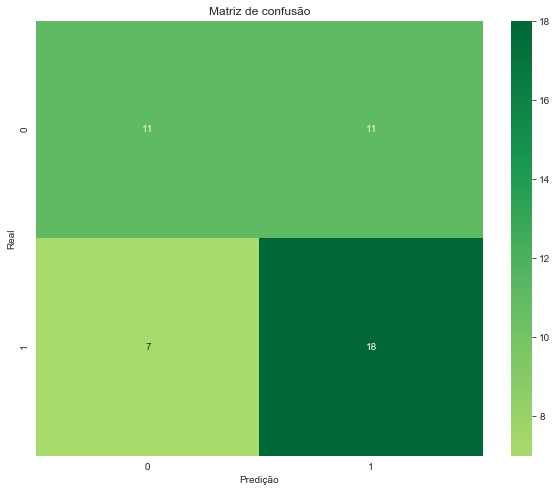

F1 score:  0.6666666666666666
Precision score:  0.6206896551724138
Accuracy score:  0.6170212765957447
MAE score:  0.34455751230219817
MSE value:  0.16859944684784453
RMSE value:  0.41060862977760776
MAPE value:  6.789427653995854


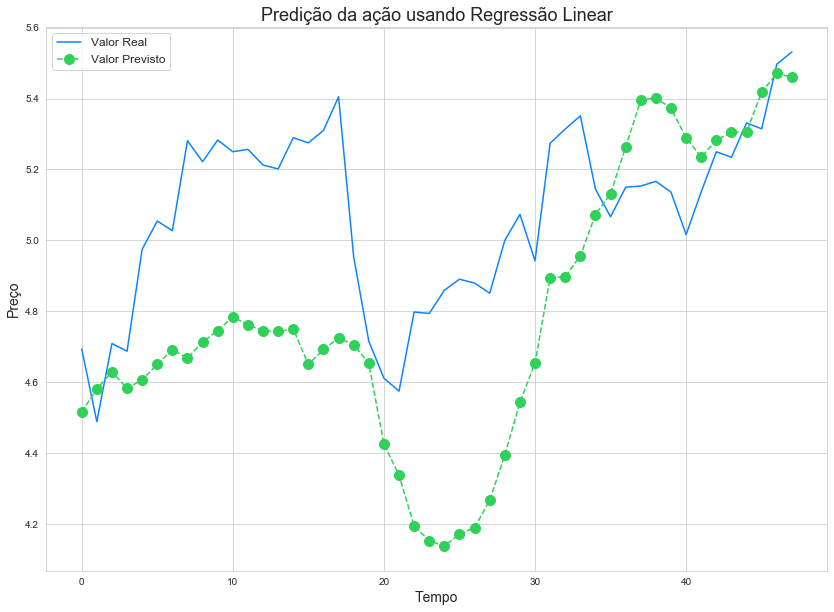

[0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 0
 0 0 0 0 0 1 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0
 0 0 0 1 1 1 0 1 0 0]


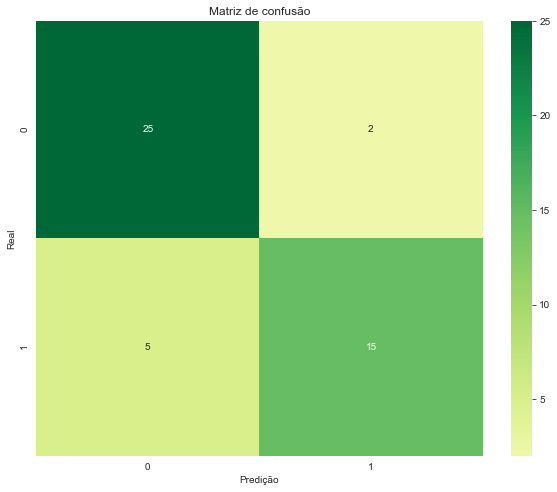

F1 score:  0.8108108108108107
Precision score:  0.8823529411764706
Accuracy score:  0.851063829787234
MAE score:  0.27816594203819395
MSE value:  0.09765716962161852
RMSE value:  0.31250147139112566
MAPE value:  1.6975563055910743


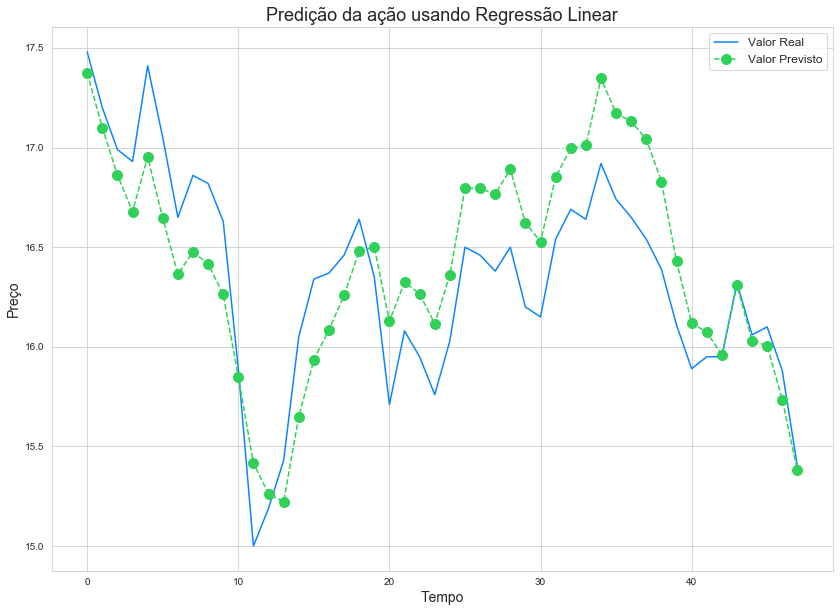

[1 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0]
[0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1
 1 0 0 1 0 1 1 0 1 1]


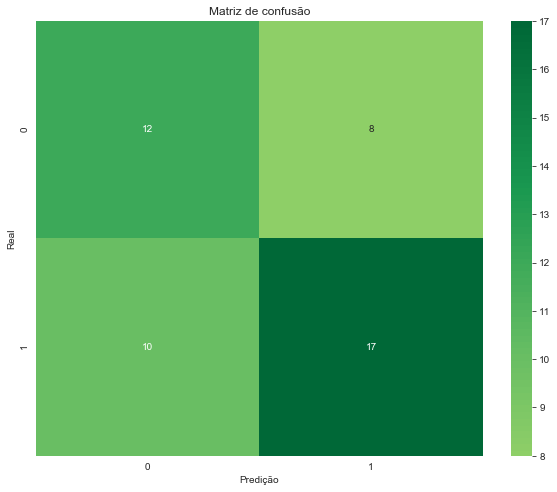

F1 score:  0.6538461538461539
Precision score:  0.68
Accuracy score:  0.6170212765957447
MAE score:  1.3034612849006735
MSE value:  2.1753757554888673
RMSE value:  1.474915507915239
MAPE value:  3.1154210149184633


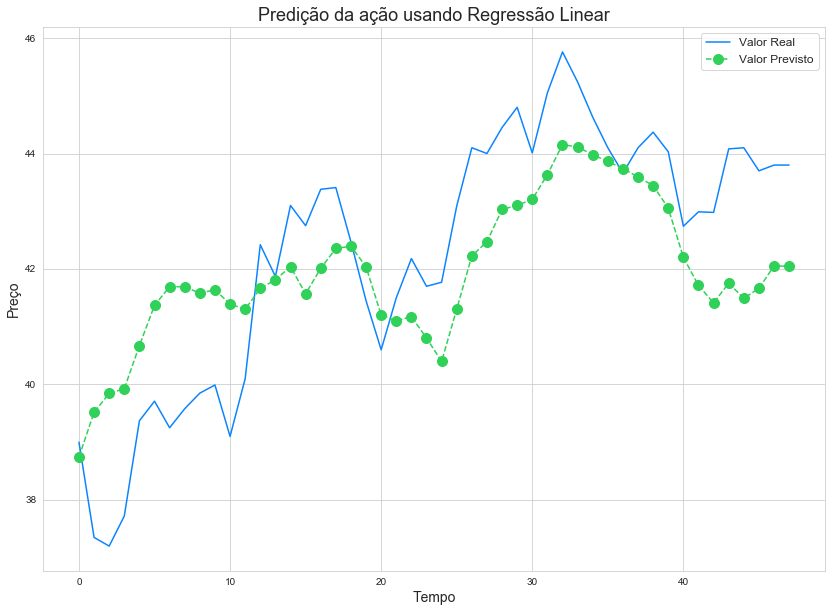

[0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 0 1 1 1 0 0]
[0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 0 1 1 1 1 0]


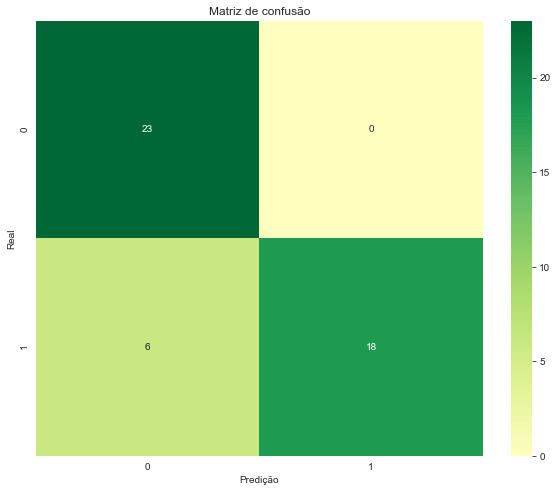

F1 score:  0.8571428571428571
Precision score:  1.0
Accuracy score:  0.8723404255319149
MAE score:  0.9163268425563985
MSE value:  1.2691549312402792
RMSE value:  1.1265677659334477
MAPE value:  1.7037873656738785


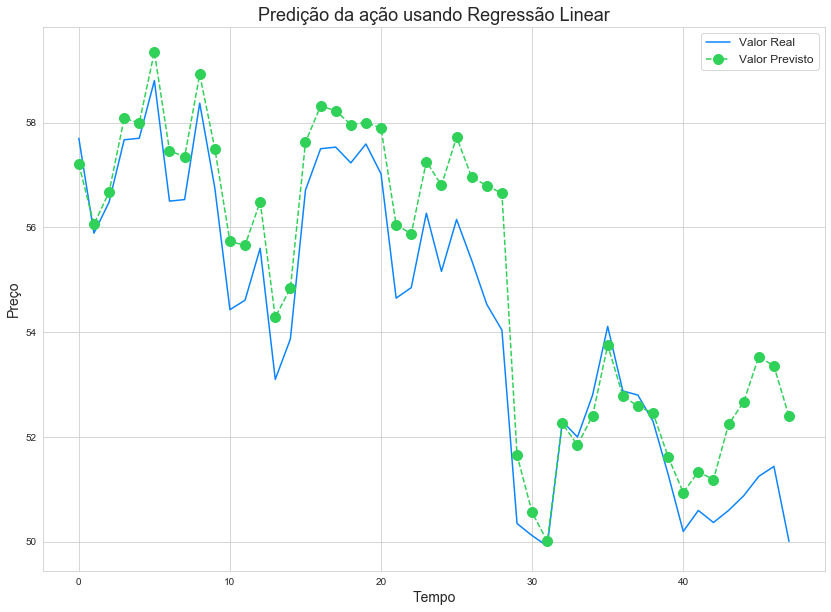

[0 0 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1
 0 0 0 1 1 1 0 0 0 1]
[0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1
 0 1 0 0 1 1 0 0 0 1]


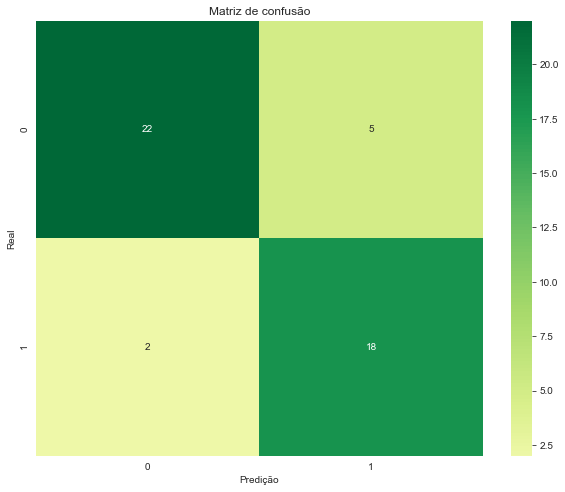

F1 score:  0.8372093023255814
Precision score:  0.782608695652174
Accuracy score:  0.851063829787234
MAE score:  2.3500128957429176
MSE value:  11.129794254726159
RMSE value:  3.336134627787997
MAPE value:  9.01714835056195


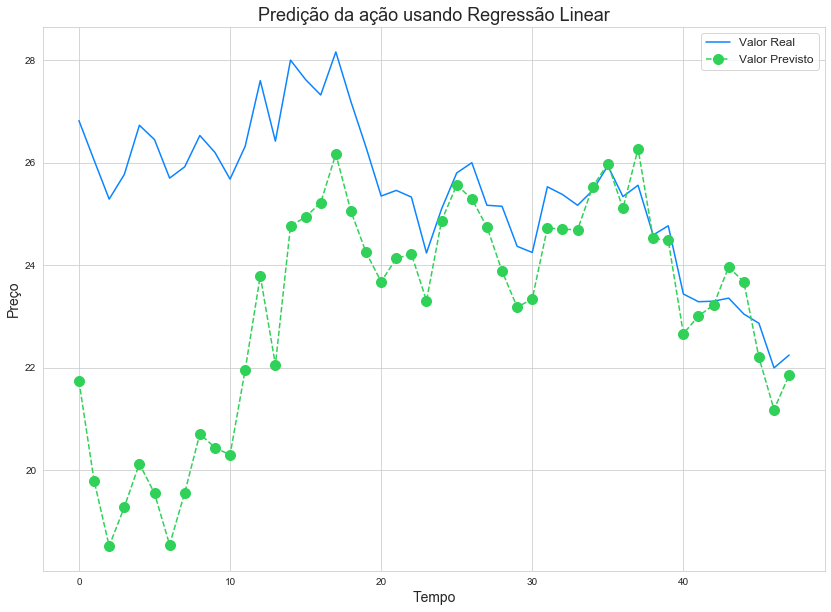

[0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1
 1 1 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 0 0 1 0 0 1 0]


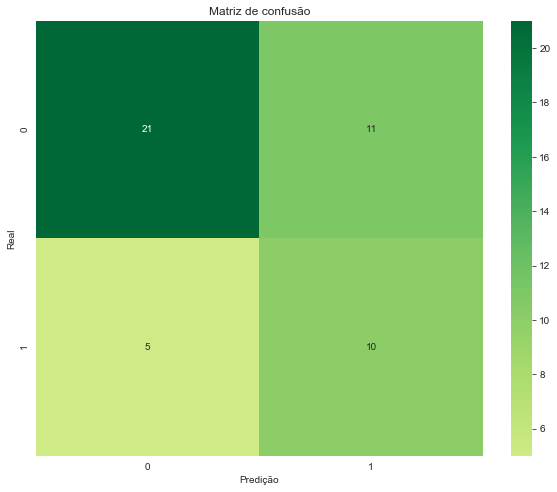

F1 score:  0.5555555555555556
Precision score:  0.47619047619047616
Accuracy score:  0.6595744680851063
MAE score:  1.6333764945617943
MSE value:  2.872713391367635
RMSE value:  1.6949080775569025
MAPE value:  7.812039969081185


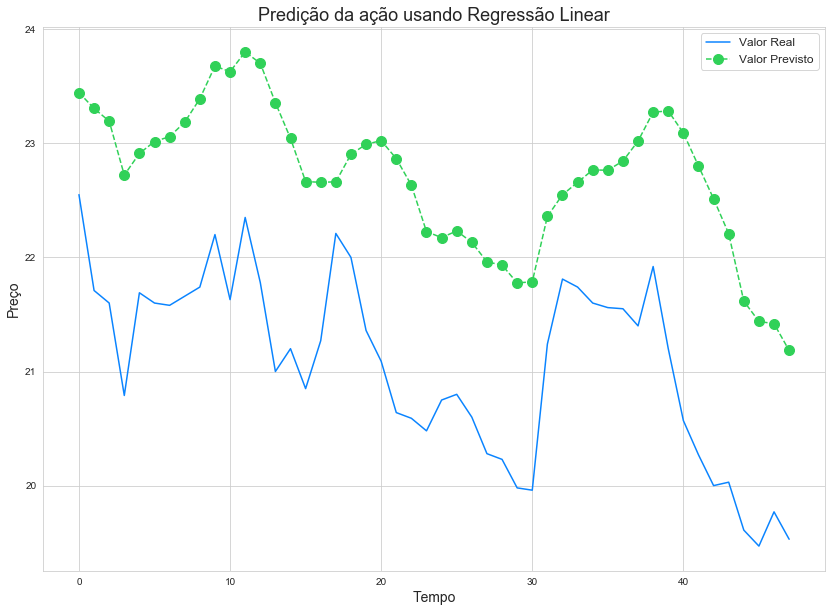

[0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0
 0 1 1 1 0 0 0 0 0 1]
[0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1
 0 1 0 1 0 0 0 0 1 0]


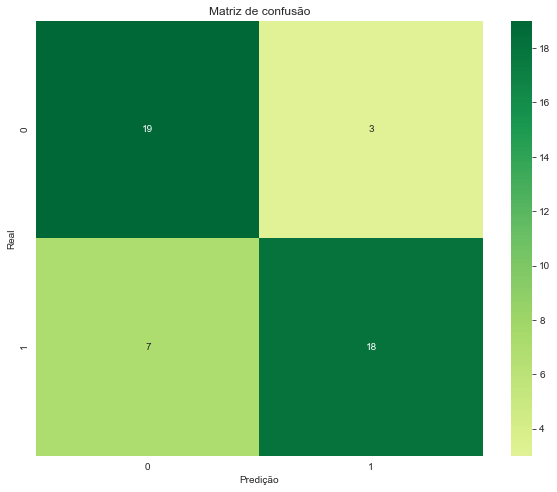

F1 score:  0.782608695652174
Precision score:  0.8571428571428571
Accuracy score:  0.7872340425531915
MAE score:  3.770120039107695
MSE value:  16.954506875165297
RMSE value:  4.117585078072498
MAPE value:  6.880734436450362


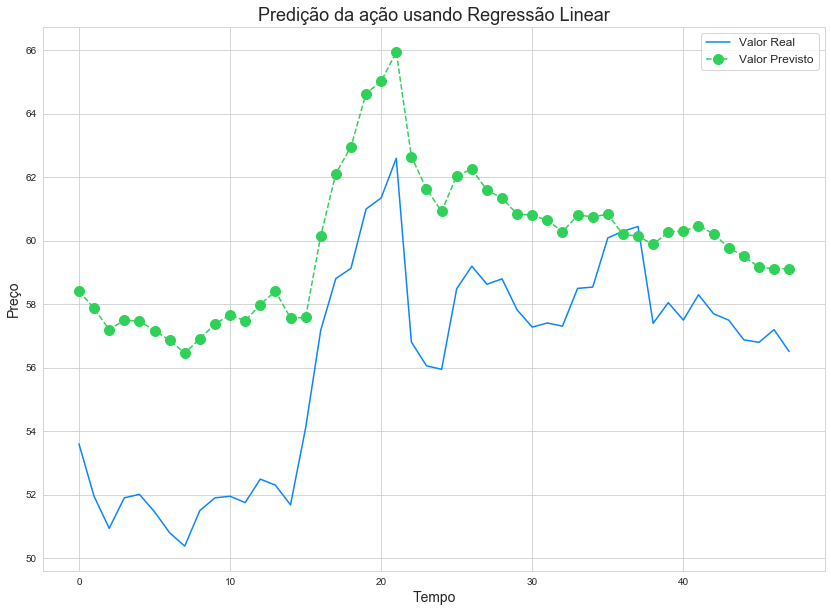

In [1089]:
predict_linear_all_stocks(historicStock)